# **From Author Profiling to Genre Clustering and Music Style Matching: A Holistic Approach to Understanding what is behind Artists' Lyrics**

1. "Author profiling" --> extract some features and see if the artists group into some genre (7 or so) clusters based on these features. The features would be obtained through sentiment analysis, mood analysis, topic modeling and then the different artists will be clustered according to genre (defined by certain characteristics). The correctness of our genre clustering will then be easily checkable.
2. Match artists based on how similar their styles are, then check on Spotify to see how artists are associated and proposed together.
3. Bonus Part: try to generate text based on the artist features we found.

We import a Kaggle dataset called "spotify_millsongdata.csv" containing song names, artists names, link to the song and lyrics.

Kaggle dataset: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

# Libraries

In [ ]:
!pip install text2emotion
!pip install contractions
!pip uninstall emoji
!pip install emoji==1.7.0

In [ ]:
# Main libraries
import pandas as pd
import numpy as np
import re
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import math
import requests
from nltk import ngrams
import contractions # to go from I'll to I will

# For collocations
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Sentiment Analysis
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# For Topic Modeling
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

# For Author Topic Modeling
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

# For Emotion Analysis
import text2emotion as te

# For Clustering

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Our Dataset
We downloaded this Spotify Million Song Dataset from Kaggle. The dataset contains song names, artists names, link to the song and lyrics.

https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

In [ ]:
df = pd.read_csv(r'spotify_millsongdata.csv', usecols = ['artist', 'song', 'link', 'text'])

In [ ]:
df.columns

Index(['artist', 'song', 'link', 'text'], dtype='object')

In [ ]:
len(df)

57650

Let's see what artists are present in the dataset

In [ ]:
df.artist.unique()

array(['ABBA', 'Ace Of Base', 'Adam Sandler', 'Adele', 'Aerosmith',
       'Air Supply', 'Aiza Seguerra', 'Alabama', 'Alan Parsons Project',
       'Aled Jones', 'Alice Cooper', 'Alice In Chains', 'Alison Krauss',
       'Allman Brothers Band', 'Alphaville', 'America', 'Amy Grant',
       'Andrea Bocelli', 'Andy Williams', 'Annie', 'Ariana Grande',
       'Ariel Rivera', 'Arlo Guthrie', 'Arrogant Worms', 'Avril Lavigne',
       'Backstreet Boys', 'Barbie', 'Barbra Streisand', 'Beach Boys',
       'The Beatles', 'Beautiful South', 'Beauty And The Beast',
       'Bee Gees', 'Bette Midler', 'Bill Withers', 'Billie Holiday',
       'Billy Joel', 'Bing Crosby', 'Black Sabbath', 'Blur', 'Bob Dylan',
       'Bob Marley', 'Bob Rivers', 'Bob Seger', 'Bon Jovi', 'Boney M.',
       'Bonnie Raitt', 'Bosson', 'Bread', 'Britney Spears',
       'Bruce Springsteen', 'Bruno Mars', 'Bryan White', 'Cake',
       'Carly Simon', 'Carol Banawa', 'Carpenters', 'Cat Stevens',
       'Celine Dion', 'Chaka Khan

But we only select a sample of them that includes the most famous one in our opinion, so that we will be able to check quicklier if our model performs well.

In [ ]:
df = df.loc[df['artist'].isin(['ABBA',
       'Adele',
       'Aerosmith',
       'Ariana Grande',
       'The Beatles',
       'Bob Dylan',
       'Bob Marley',
       'Britney Spears',
       'Bruce Springsteen',
       'Bruno Mars',
       'Chris Brown',
       'Coldplay',
       'David Bowie',
       'Drake''Ed Sheeran',
       'Elton John',
       'Elvis Presley',
       'Eminem',
       'Frank Sinatra',
       "Guns N' Roses",
       'High School Musical',
       'Iggy Pop',
       'Imagine Dragons',
       'J Cole',
       'Jennifer Lopez',
       'John Legend',
       'Jimi Hendrix',
       'Justin Bieber',
       'Justin Timberlake',
       'Kanye West',
       'Katy Perry',
       'Lady Gaga',
       'Lana Del Rey',
       'Linkin Park',
       'Lorde',
       'Maroon 5',
       'Metallica',
       'Michael Buble',
       'Michael Jackson',
       'Nirvana',
       'Notorious B.I.G.',
       'One Direction',
       'OneRepublic',
       'Pharrell Williams',
       'Phil Collins',
       'P!nk',
       'Pink Floyd',
       'Pitbull',
       'Point Of Grace',
       'Primus',
       'Prince',
       'Queen',
       'Radiohead',
       'Ramones',
       'Ray Charles',
       'Red Hot Chili Peppers',
       'Richard Marx',
       'Rihanna',
       'Robbie Williams',
       'Rod Stewart',
       'Rolling Stones',
       'Rush',
       'Sam Smith',
       'Santana',
       'Selena Gomez',
       'Sia',
       'Smiths',
       'Snoop Dogg',
       'System Of A Down',
       'Stevie Wonder',
       'Sting',
       'Stone Roses',
       'Stone Temple Pilots',
       'Sublime',
       'Supertramp',
       'The Weeknd',
       'Tori Amos',
       'Toto',
       'Townes Van Zandt',
       'Tracy Chapman',
       'Travis',
       'Twenty One Pilots',
       'U2',
       'Ugly Kid Joe',
       'Uncle Tupelo',
       'Underoath',
       'Underworld',
       'Van Morrison',
       'Vanessa Williams',
       'Vanilla Ice',
       'Velvet Underground',
       'Vengaboys',
       'Venom',
       'Vera Lynn',
       'Whitney Houston',
       'Who',
       'Widespread Panic',
       'Will Smith',
       'Wiz Khalifa',
       'Wu-Tang Clan',
       'Yo La Tengo',
       'Yoko Ono',
       'Yolanda Adams',
       'Youngbloodz',
       'Ziggy Marley',
       'Zucchero'])]

In [ ]:
df

artist                   song  \
0              ABBA  Ahe's My Kind Of Girl   
1              ABBA       Andante, Andante   
2              ABBA         As Good As New   
3              ABBA                   Bang   
4              ABBA       Bang-A-Boomerang   
...             ...                    ...   
57642  Ziggy Marley                 Friend   
57643  Ziggy Marley                     G7   
57644  Ziggy Marley             Generation   
57645  Ziggy Marley          Good Old Days   
57646  Ziggy Marley          Hand To Mouth   

                                              link  \
0       /a/abba/ahes+my+kind+of+girl_20598417.html   
1            /a/abba/andante+andante_20002708.html   
2             /a/abba/as+good+as+new_20003033.html   
3                       /a/abba/bang_20598415.html   
4           /a/abba/bang+a+boomerang_20002668.html   
...                                            ...   
57642         /z/ziggy+marley/friend_20673508.html   
57643             /z/ziggy+marley/g7_20531173.html   
57644     /z/ziggy+marley/generation_20531171.html   
57645  /z/ziggy+marley/good+old+days_10198588.html   
57646  /z/ziggy+marley/hand+to+mouth_20531167.html   

                                                    text  
0      Look at her face, it's a wonderful face  \r\nA...  
1      Take it easy with me, please  \r\nTouch me gen...  
2      I'll never know why I had to go  \r\nWhy I had...  
3      Making somebody happy is a question of give an...  
4      Making somebody happy is a question of give an...  
...                                                  ...  
57642  [Chorus]  \r\nI wanna thank you for the things...  
57643  Seven richest countries in the world  \r\nThem...  
57644  Many generation have passed away  \r\nFighting...  
57645  Irie days come on play  \r\nLet the angels fly...  
57646  Power to the workers  \r\nMore power  \r\nPowe...  

[10077 rows x 4 columns]

So this are the artist we are considering for our analysis:

In [ ]:
df.artist.unique()

array(['ABBA', 'Adele', 'Aerosmith', 'Ariana Grande', 'The Beatles',
       'Bob Dylan', 'Bob Marley', 'Britney Spears', 'Bruce Springsteen',
       'Bruno Mars', 'Chris Brown', 'Coldplay', 'David Bowie',
       'Elton John', 'Elvis Presley', 'Eminem', 'Frank Sinatra',
       "Guns N' Roses", 'High School Musical', 'Iggy Pop',
       'Imagine Dragons', 'J Cole', 'Jennifer Lopez', 'Jimi Hendrix',
       'John Legend', 'Justin Bieber', 'Justin Timberlake', 'Kanye West',
       'Katy Perry', 'Lady Gaga', 'Lana Del Rey', 'Linkin Park', 'Lorde',
       'Maroon 5', 'Metallica', 'Michael Buble', 'Michael Jackson',
       'Nirvana', 'Notorious B.I.G.', 'One Direction', 'OneRepublic',
       'Pharrell Williams', 'Phil Collins', 'Pink Floyd', 'Pitbull',
       'P!nk', 'Point Of Grace', 'Primus', 'Prince', 'Queen', 'Radiohead',
       'Ramones', 'Ray Charles', 'Red Hot Chili Peppers', 'Richard Marx',
       'Rihanna', 'Robbie Williams', 'Rod Stewart', 'Rolling Stones',
       'Rush', 'Sam Smith',

In [ ]:
len(df.artist.unique())

104

We have a sample of 104 artist.

In [ ]:
df.to_csv('nlp_dataset.csv')

In [ ]:
df=pd.read_csv('nlp_dataset.csv').drop('Unnamed: 0',axis=1)
df=df.drop('link', axis=1)
df=df.drop('song', axis=1)
df

artist                                               text
0              ABBA  Look at her face, it's a wonderful face  \r\nA...
1              ABBA  Take it easy with me, please  \r\nTouch me gen...
2              ABBA  I'll never know why I had to go  \r\nWhy I had...
3              ABBA  Making somebody happy is a question of give an...
4              ABBA  Making somebody happy is a question of give an...
...             ...                                                ...
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...

[10077 rows x 2 columns]

Let's check how many lyrics per artist we have

In [ ]:
#how many songs per artist
lyrics_count = df.groupby('artist')['text'].count()
pd.set_option('display.max_rows', None)

print(lyrics_count)

# Reset the display option to its default value
pd.reset_option('display.max_rows')

artist
ABBA                     113
Adele                     54
Aerosmith                171
Ariana Grande             51
Bob Dylan                188
Bob Marley                86
Britney Spears           158
Bruce Springsteen        175
Bruno Mars                70
Chris Brown              145
Coldplay                 120
David Bowie              165
Elton John               175
Elvis Presley            168
Eminem                    70
Frank Sinatra            154
Guns N' Roses             93
High School Musical       18
Iggy Pop                 177
Imagine Dragons           41
J Cole                    68
Jennifer Lopez           110
Jimi Hendrix             127
John Legend               93
Justin Bieber            131
Justin Timberlake         60
Kanye West               106
Katy Perry                89
Lady Gaga                137
Lana Del Rey             113
Linkin Park              125
Lorde                     15
Maroon 5                 110
Metallica                155
Michael

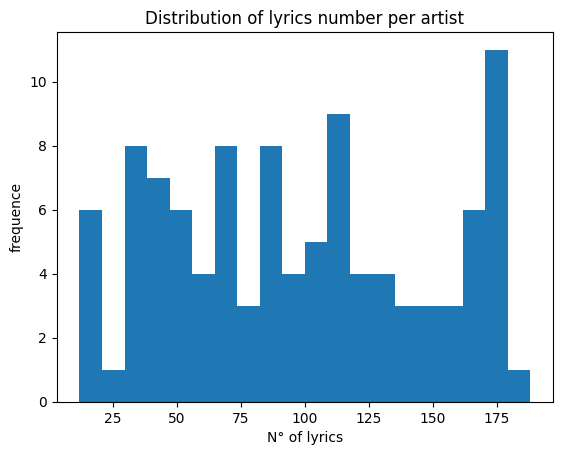

In [ ]:
import matplotlib.pyplot as plt

lyrics_count = df.groupby('artist')['text'].count()

plt.hist(lyrics_count, bins=20)
plt.xlabel('N° of lyrics')
plt.ylabel('frequence')
plt.title('Distribution of lyrics number per artist')
plt.show()

As we can see, the number of lyrics varies significantly across artists. The range starts from as low as 12 lyrics for Vera Lynn and goes up to 188 lyrics for Bob Dylan.

This may introduce a bias in the genre clustering. Artists with a larger number of lyrics may have a greater influence on the clustering process due to having more data. This could result in a skewed representation of certain genres if those genres are predominantly represented by artists with a higher number of lyrics, so we will need to take this into account further on in our analysis.

# 1. Pre-processing the lyrics text


To pre-process the lyrics of the songs, we initially removed stopwords, punctuation and non-alphanumeric characters; in addition, we have transformed the abbreviations into their extended form, so that they can be removed more easily. Subsequently, we applied the lemmatization technique to significantly reduce the variability of the data. In comparison with other pre-processing techniques, this seemed the most appropriate, both in terms of performances and for interpretative needs, which we will see later.

In [ ]:
# Define a preprocess function
def preprocess(text):

    # extend contractions
    text = contractions.fix(text)

    # remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # lowercase the text
    text = text.lower()

    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # remove stopwords
    stop_words = [w.lower() for w in stopwords.words('english')]
    stop_words.extend(['chorus', 'make', 'take'])
    text = ' '.join([w for w in text.split(' ') if w.lower() not in stop_words])

    # lemmatize the text
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])

    return text

In [ ]:
preprocess("I'll never know why I had ")

'never know'

In [ ]:
df["prep_text"] = df["text"].apply(preprocess)
df

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  
0      look face wonderful face mean something specia...  
1      easy please touch gently like summer evening b...  
2      never know go put lousy rotten show boy tough ...  
3      make somebody happy question give learn show c...  
4      make somebody happy question give learn show c...  
...                                                  ...  
10072  want thank thing do want thank generosity neve...  
10073  seven rich country world little meeting plan k...  
10074  many generation pass away fighting fight today...  
10075  irie day come play let angel fly let devil die...  
10076  power worker power power worker need power pow...  

[10077 rows x 3 columns]

In [ ]:
df.to_csv('nlp_dataset_prep.csv')

In [ ]:
df=pd.read_csv('nlp_dataset_prep.csv', sep=",").drop('Unnamed: 0',axis=1)
df.head(5)

artist                                               text  \
0   ABBA  Look at her face, it's a wonderful face  \r\nA...   
1   ABBA  Take it easy with me, please  \r\nTouch me gen...   
2   ABBA  I'll never know why I had to go  \r\nWhy I had...   
3   ABBA  Making somebody happy is a question of give an...   
4   ABBA  Making somebody happy is a question of give an...   

                                           prep_text  
0  look face wonderful face mean something specia...  
1  easy please touch gently like summer evening b...  
2  never know go put lousy rotten show boy tough ...  
3  make somebody happy question give learn show c...  
4  make somebody happy question give learn show c...

## Find and replace collocations

Now we want to extract meaningful bigram collocations from a collection of texts. By identifying and analyzing consecutive pairs of words (bigrams) we want to uncover important associations and patterns.



In [ ]:
words = [word for text in df['prep_text'] for word in text.split()]

finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like

# we choose 4 as threshold for collocations
collocations = set({" ".join(bigram): scoring for bigram, scoring in finder.score_ngrams(score) if scoring >= 4})

In [ ]:
def replace_collocations(s):
    s = s.split()
    i = 0
    while i <= len(s) - 2:
        if str(s[i] + " " + s[i+1]) in collocations:
            s[i] = s[i] + "_" + s.pop(i+1)
        i += 1
    s = " ".join(s)
    return s
final_text = [replace_collocations(string) for string in df['prep_text']]

In [ ]:
# Replace
df['prep_text_for_bigrams'] = final_text

## Create train, dev and test sets

In [ ]:
# create training set
train = df.sample(frac=0.7,random_state = 22)
not_train = df.drop(train.index)

# create development set
dev = not_train.sample(frac = 0.5, random_state = 22)

# create test set
test = not_train.drop(dev.index)

# reset indexes of all
train.reset_index(drop = True, inplace = True)
dev.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

# Exploratory Data Analysis

## Most frequent bigrams and trigrams

Now what we do here is to analyze the frequency of bigrams and trigrams. By examining these consecutive word combinations, we can gain insights into common phrases or patterns that occur within the lyrics.



In [ ]:
all_texts = ' '.join(df['prep_text_for_bigrams'])
words = all_texts.split()

# Generate bigrams and trigrams
bigrams = list(ngrams(words, 2))
trigrams = list(ngrams(words, 3))

# Count the occurrences of each bigram and trigram
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# Get the most frequent bigrams and trigrams
most_common_bigrams = bigram_counts.most_common(30)
most_common_trigrams = trigram_counts.most_common(30)


print("Most frequent bigrams\t\t\t\tMost frequent trigrams")
for (bigram, bigram_count), (trigram, trigram_count) in zip(most_common_bigrams, most_common_trigrams):
    print(f"{' '.join(bigram):<30}{bigram_count}\t\t{' '.join(trigram):<30}{trigram_count}")

Most frequent bigrams				Most frequent trigrams
go go                         1136		la_la la_la la_la             501
get get                       885		go go go                      490
la_la la_la                   735		oh_oh oh_oh oh_oh             353
oh_oh oh_oh                   685		get get get                   319
want want                     637		na_na na_na na_na             249
come come                     612		come come come                240
want know                     588		want want want                197
go get                        545		girl girl girl                179
got get                       534		say say say                   174
can_not see                   523		yeah_yeah yeah_yeah yeah_yeah 149
know want                     503		run run run                   147
say say                       476		give give give                140
let_we go                     470		ooh_ooh ooh_ooh ooh_ooh       125
want see                      469		right right right  

The output we get is interesting: the most frequent bigrams reveal commonly occurring phrases, such as "do_not know," "I_m go_to," and "do_not want." These combinations can suggest expressions of uncertainty, desire, and actions performed by the artists. Similarly, the most frequent trigrams exhibit patterns like "la_la la_la la_la," "oh_oh oh_oh oh_oh," and "know know know." These trigrams involve repeated sounds or words, emphasizing certain parts of the lyrics for rhythmic or melodic effect.



# Sentiment Analysis

Now we are going to perform some sentiment analysis for each artist's lyrics. The score is determined based on how positive or negative the text is, with negative scores indicating negative sentiment and positive scores indicating positive sentiment.

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [ ]:
def get_sentiment_score(prep_text):
    return sentiment_analyzer.polarity_scores(prep_text)['compound']

In [ ]:
df['sentiment_score'] = df['prep_text'].apply(get_sentiment_score)
df

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  sentiment_score  
0      look face wonderful face mean something specia...           0.9840  
1      easy please touch gently like summer evening b...           0.9922  
2      never know go put lousy rotten show boy tough ...           0.9980  
3      make somebody happy question give learn show c...           0.9977  
4      make somebody happy question give learn show c...           0.9977  
...                                                  ...              ...  
10072  want thank thing do want thank generosity neve...           0.1606  
10073  seven rich country world little meeting plan k...           0.4588  
10074  many generation pass away fighting fight today...          -0.9571  
10075  irie day come play let angel fly let devil die...           0.9460  
10076  power worker power power worker need power pow...          -0.2263  

[10077 rows x 4 columns]

In [ ]:
grouped_data = df.groupby('artist')['sentiment_score'].mean().reset_index()
grouped_data.to_csv('nlp_proportions0.csv')

The graph below can help identify which artists have predominantly positive or negative sentiment scores, as well as the distribution of sentiment scores among all the artists. We plot indeed the sentiment score distribution of artists, with each point representing an artist and its sentiment score

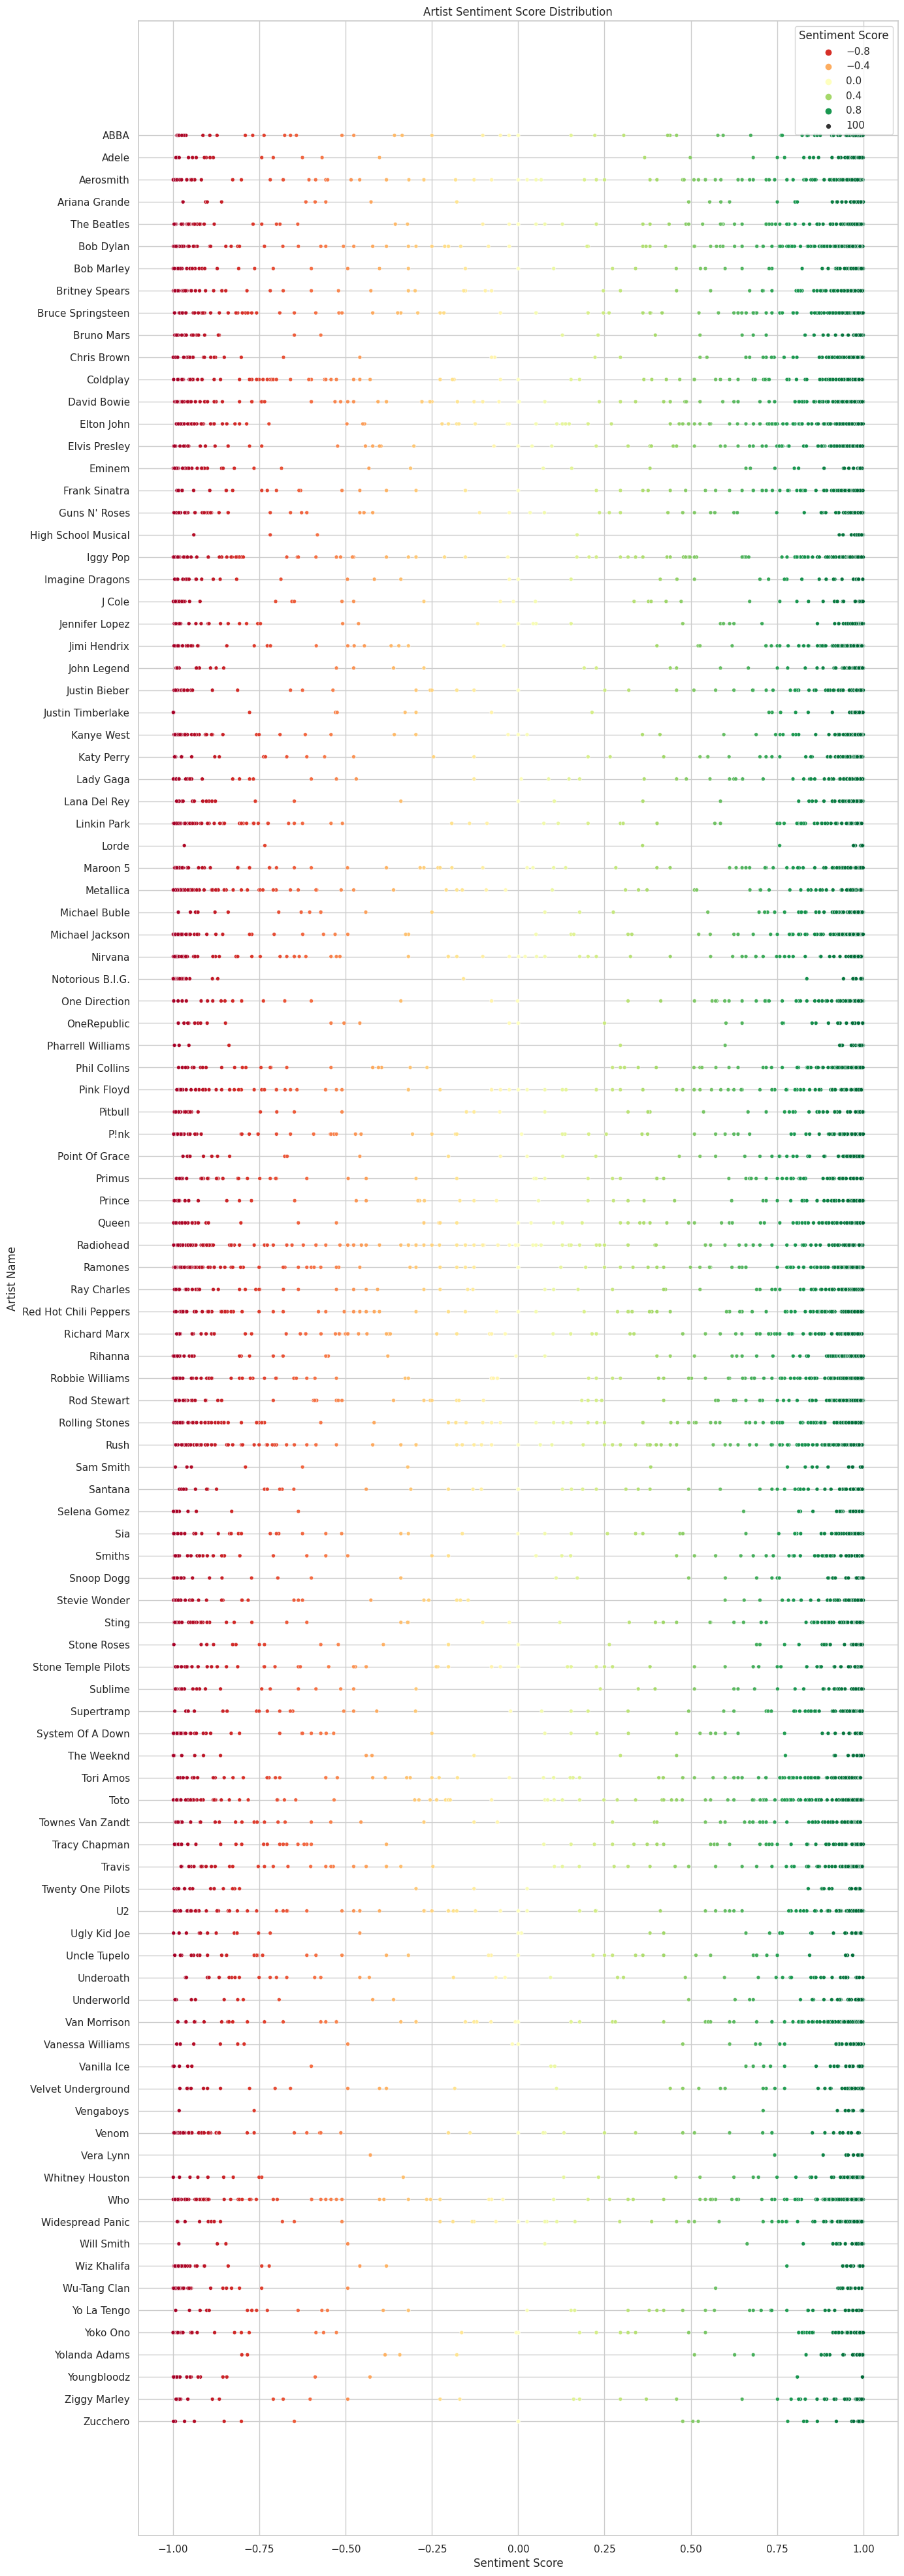

In [ ]:
import seaborn as sns
plt.figure(figsize=(15, 50))
sns.set(style="whitegrid")
ax = sns.scatterplot(x="sentiment_score", y="artist", hue="sentiment_score", data=df, palette="RdYlGn", size=100)
ax.legend().set_title('Sentiment Score')
ax.set(xlabel='Sentiment Score', ylabel='Artist Name')
ax.set_title("Artist Sentiment Score Distribution")
plt.show()

With the graph below we aim to show the distribution of sentiment scores for artists based on the number of songs they have produced. Artists are grouped by name, and for each artist, the average of sentiment scores and the number of songs produced. The attribute 'sentiment_category' is created, indicating whether the artist mainly has songs with a positive or negative sentiment score.

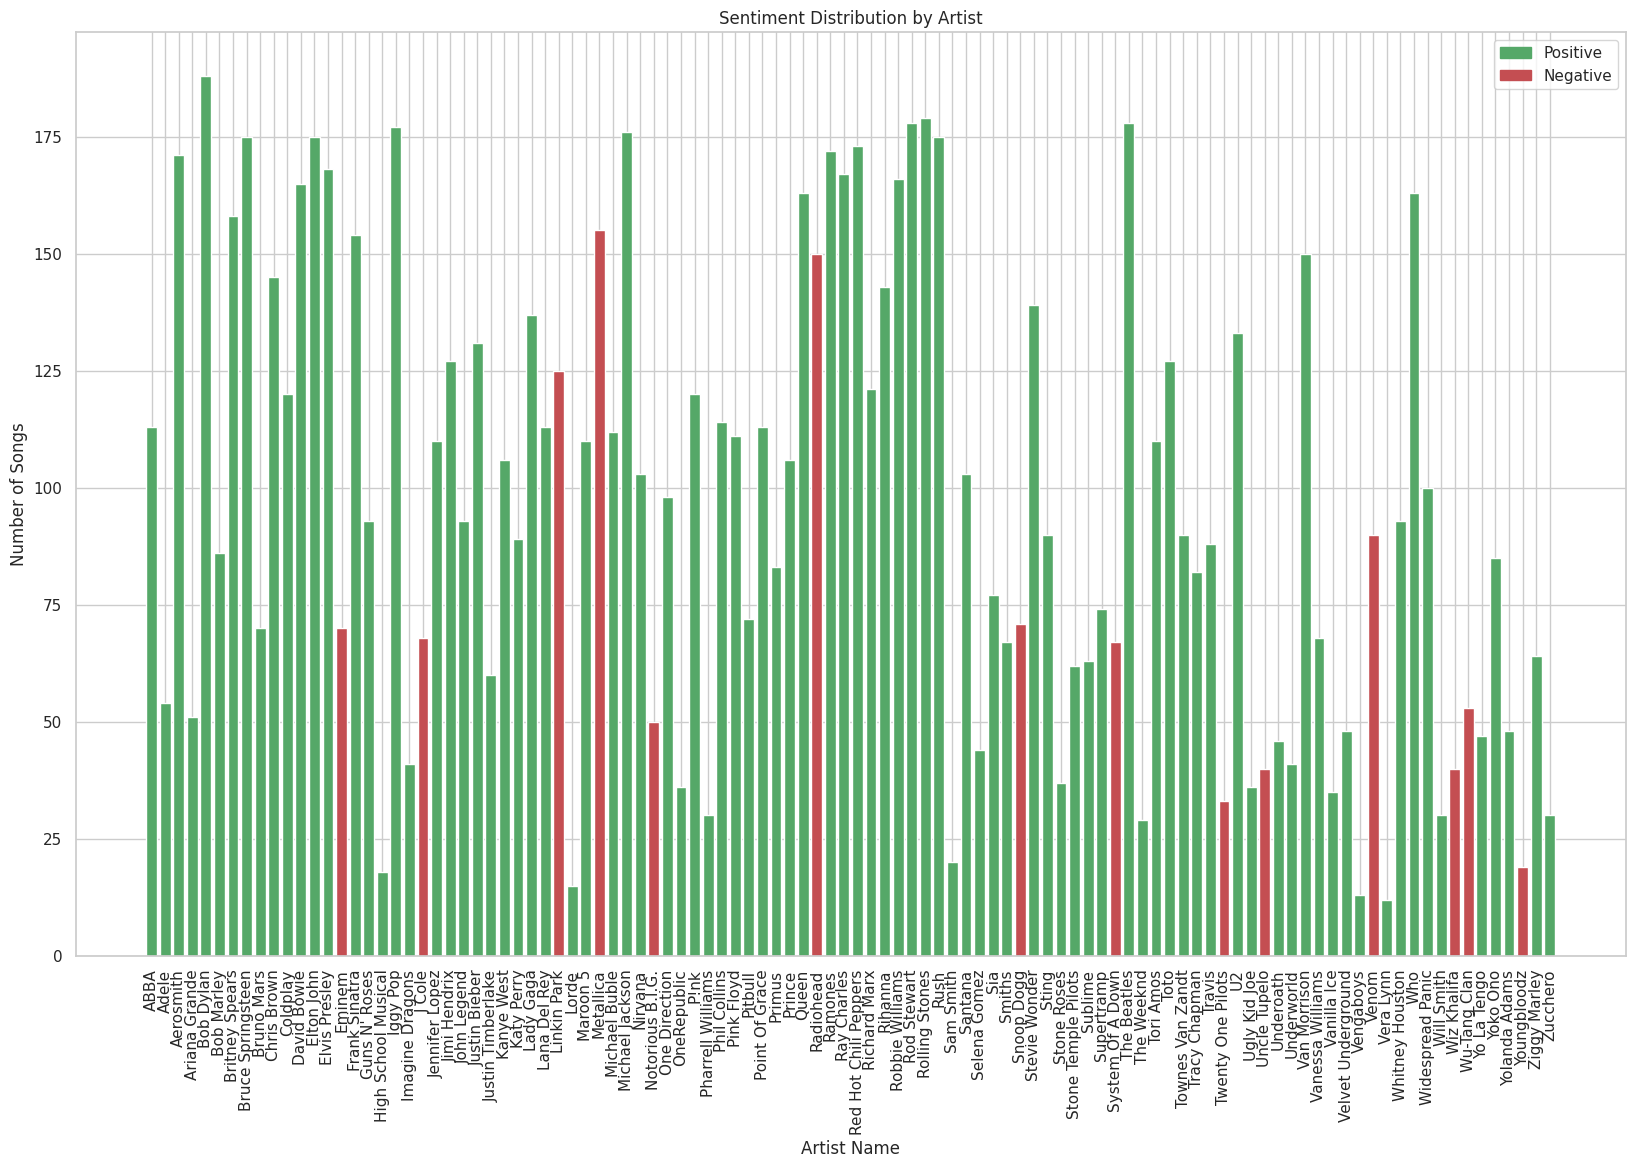

In [ ]:
artist_sentiment = df.groupby('artist')['sentiment_score'].agg(['count', 'mean'])

artist_sentiment['sentiment_category'] = 'Positive'
artist_sentiment.loc[artist_sentiment['mean'] < 0, 'sentiment_category'] = 'Negative'

plt.figure(figsize=(20,12))
plt.bar(artist_sentiment.index, artist_sentiment['count'], color=artist_sentiment['sentiment_category'].map({'Positive': 'g', 'Negative': 'r'}))

plt.xlabel('Artist Name')
plt.ylabel('Number of Songs')
plt.title('Sentiment Distribution by Artist')

plt.xticks(rotation='vertical')

positive_patch = plt.Rectangle((0,0), 1, 1, color='g', label='Positive')
negative_patch = plt.Rectangle((0,0), 1, 1, color='r', label='Negative')
plt.legend(handles=[positive_patch, negative_patch], loc='upper right')

plt.show()

# Author Topic Modeling

With the author topic analysis we aim to extract  topics from the lyrics of songs produced by different artists.

In [ ]:
author2doc = defaultdict(list) # mapping from artist to document

for i, artist in enumerate(df['artist']):
    author2doc[artist].append(i)

len(author2doc)

104

In [ ]:
print(len(author2doc['Whitney Houston']))

93


We remove again some stopwords before the author topic modeling that do not carry significant meaning and are often used in songs' lyrics, in order to focus on more meaningful words.



In [ ]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah', 'yes', 'hey','whoa','woah','way', 'tha','tell', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa','chorus', 'make', 'take', 'still', 'give', 'wanna', 'want', 'come', 'one', 'let', 'look', 'think', 'thing', 'well','try', 'could', 'cause']
stop_words.extend(new_stop_words)
def remove_stopwords(text):
  textarr = text.split(' ')
  rem_text = ' '.join([i for i in textarr if (i.lower() not in stop_words and len(i.lower())>2)])
  return rem_text

In [ ]:
df['prep_text2'] = df['prep_text'].apply(remove_stopwords)
df.head()

artist                                               text  \
0   ABBA  Look at her face, it's a wonderful face  \r\nA...   
1   ABBA  Take it easy with me, please  \r\nTouch me gen...   
2   ABBA  I'll never know why I had to go  \r\nWhy I had...   
3   ABBA  Making somebody happy is a question of give an...   
4   ABBA  Making somebody happy is a question of give an...   

                                           prep_text  \
0  look face wonderful face mean something specia...   
1  easy please touch gently like summer evening b...   
2  never know go put lousy rotten show boy tough ...   
3  make somebody happy question give learn show c...   
4  make somebody happy question give learn show c...   

                               prep_text_for_bigrams  sentiment_score  \
0  look face wonderful face mean something specia...           0.9840   
1  easy please touch gently like summer evening b...           0.9922   
2  never know go put lousy rotten show boy tough ...           0.9980   
3  make somebody happy question give learn show c...           0.9977   
4  make somebody happy question give learn show c...           0.9977   

                                          prep_text2  
0  face wonderful face mean something special smi...  
1  easy please touch gently like summer evening b...  
2  never know put lousy rotten show boy tough pac...  
3  somebody happy question learn show break every...  
4  somebody happy question learn show break every...

Here we aim to create a dictionary that captures the most relevant and informative words while filtering out noise and less meaningful terms. This prepares the data for the subsequent author topic modeling by reducing the impact of uncommon and overly frequent words, which could potentially introduce biases or distort the topic analysis.

In [ ]:
instances = df['prep_text2'].apply(str.split).tolist()
print("creating dictionary", flush=True)

# read in instances and create Dictionary object w information about frequencies etc.
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=25, no_above=0.30)
print(dictionary, flush=True)

creating dictionary
Dictionary<2937 unique tokens: ['believe', 'blue', 'ever', 'ever_leave', 'face']...>


In [ ]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

translating corpus to IDs
tf-idf transformation


In [ ]:
print(instances[0]) # original input
print()
print(ldacorpus[0]) # hashed BOW version
print()

['face', 'wonderful', 'face', 'mean', 'something', 'special', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'feel', 'fine', 'ever', 'believe', 'mine', 'kind', 'girl', 'without', 'blue', 'ever', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'plan', 'kind', 'girl', 'feel', 'fine', 'ever', 'believe', 'mine', 'kind', 'girl', 'without', 'blue', 'ever', 'leave']

[(0, 2), (1, 2), (2, 4), (4, 2), (6, 1), (7, 1), (8, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (23, 2), (105, 4), (110, 2), (209, 1), (224, 1), (228, 2), (323, 4), (509, 2), (594, 1), (620, 1)]

[(0, 0.18648420002929023), (1, 0.21003429878745447), (2, 0.3258814527400085), (4, 0.16596185758212423), (6, 0.24000994394928168), (7, 0.0771927466018045), (8, 0.1477312346881582), (10, 0.1778403579521373), (11, 0.09324210001464511), (12, 0.20307120270369813), (13, 0.14255290065040063), (14, 0.10202223015043269), (15, 0.20158148922153848), (16, 0.0939999477288081), 

Now, we are performing topic modeling using the Author-Topic Model and evaluating the coherence of the generated topics.

In [ ]:
coherence_values = []
author_model_list = []

dev_author2doc = {key: [idx for idx in value] for key, value in author2doc.items()}

for num_topics in range(4, 13):
    author_model = AuthorTopicModel(corpus=list(ldacorpus),
                                    author2doc=dev_author2doc, # the only difference to LDA
                                    id2word=dictionary,
                                    num_topics=num_topics,
                                    alpha=0.25,
                                    eta = 'auto',
                                    random_state=42,
                                    passes=10,
                                    iterations=50
                                   )

    coherencemodel_umass = CoherenceModel(model=author_model,
                                          texts=instances,
                                          dictionary=dictionary,
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model,
                                       texts=instances,
                                       dictionary=dictionary,
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()

    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

4 -2.0413352875553157 0.3482141571382741


5 -2.116056840581379 0.34647698729539333
6 -2.127532570635901 0.3591028627654174
7 -2.236291313199547 0.3509199538242603
8 -1.911444999747269 0.3581681996236376
9 -2.2359537789406385 0.35731186195896475
10 -2.1199663337774304 0.37096582229520725
11 -2.207222864618118 0.3641400646331988
12 -2.4715318059696023 0.34132117135423434


Let's check the best number of topics we need to consider

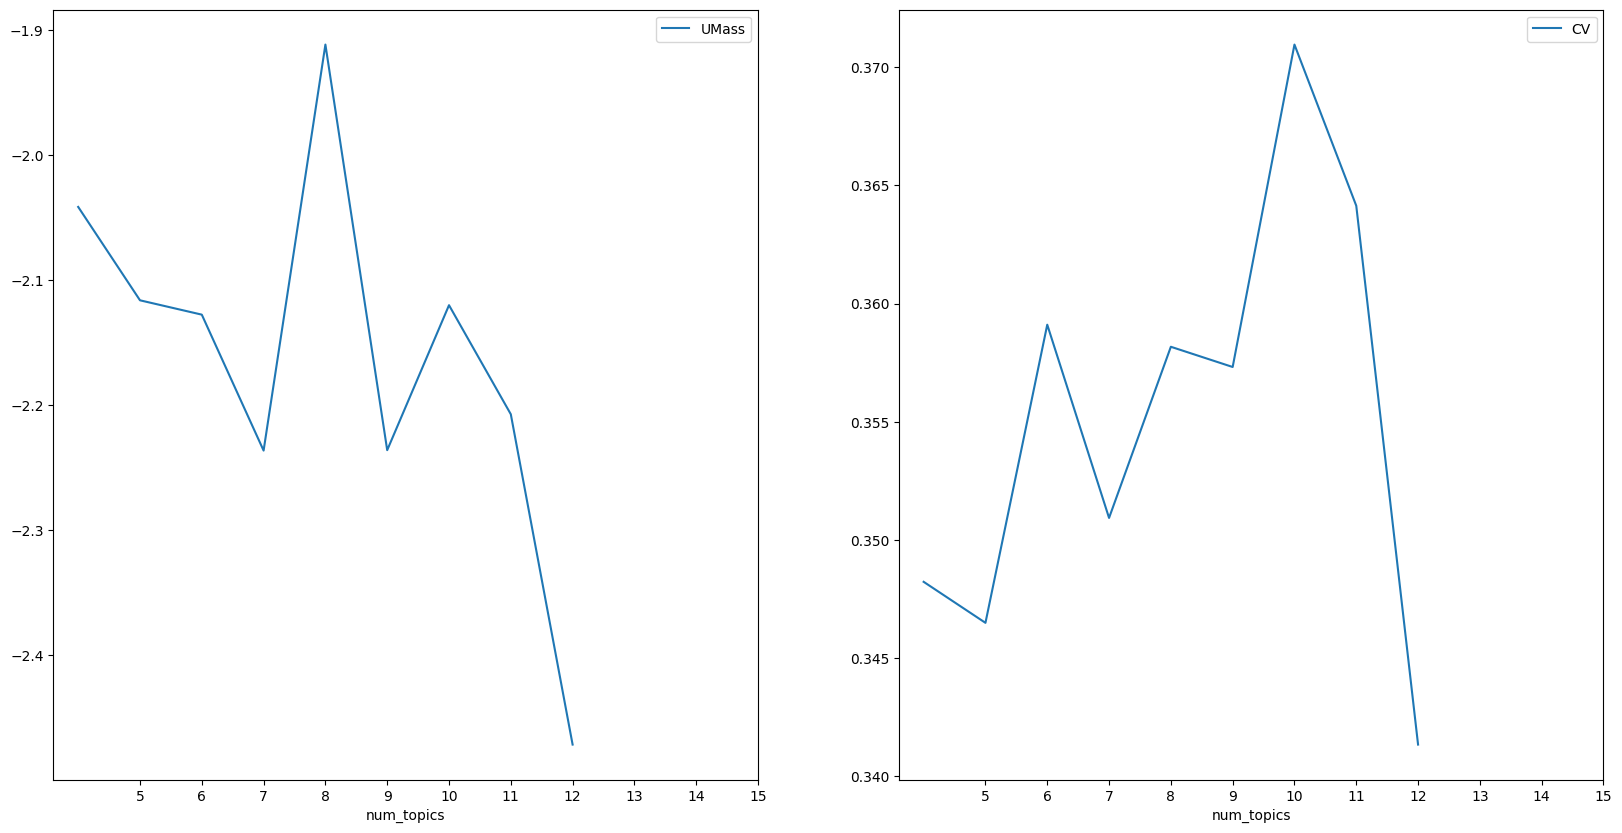

In [ ]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [ ]:
# train model with best number of topics
n_topics_author = 10

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

author_model = AuthorTopicModel(corpus=list(ldacorpus),
                                author2doc=author2doc,
                                id2word=dictionary,
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.25,
                                eta = 'auto',
                                random_state=42
)

503.85


In [ ]:
# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting

In [ ]:
# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=8)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:8]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "boy", "shake", "play", "put", "right", "hand", "mine", "party"
2 "man", "drive", "big", "hustle", "town", "car", "street", "ride"
3 "man", "hell", "old", "weight", "back", "head", "time", "good"
4 "everybody", "dem", "work", "generation", "mad", "bout", "talk", "keep"
5 "day", "time", "life", "would", "long", "heart", "find", "dream"
6 "feel", "never", "time", "need", "right", "back", "would", "leave"
7 "day", "power", "free", "beat", "kill", "sound", "shoot", "watch"
8 "god", "lord", "pay", "road", "matter", "die", "high", "hand"
9 "baby", "girl", "dance", "got", "tonight", "little", "home", "night"
10 "big", "nigga", "shit", "chop", "bitch", "money", "fuck", "wit"


In [ ]:
# initialize mapping from covariate(=author/country) to topic distro, set all to 0.0
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
# update mappings from model
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v


target_authors = list(set([x for x in df.artist]))
for author in target_authors:
    print(author, author_vecs[author])

Yolanda Adams {'boy, shake': 0.0, 'man, drive': 0.021248558662719335, 'man, hell': 0.0, 'everybody, dem': 0.0, 'day, time': 0.28205339475987157, 'feel, never': 0.3114699196420738, 'day, power': 0.02674617040415408, 'god, lord': 0.3335349786998261, 'baby, girl': 0.010631634886312823, 'big, nigga': 0.0}
Maroon 5 {'boy, shake': 0.02041514320258301, 'man, drive': 0.05154843597892471, 'man, hell': 0.06693312317650657, 'everybody, dem': 0.0, 'day, time': 0.2528185256553634, 'feel, never': 0.4533204996695132, 'day, power': 0.04180966494184677, 'god, lord': 0.02639271533844042, 'baby, girl': 0.07025154457584161, 'big, nigga': 0.012308758015953337}
System Of A Down {'boy, shake': 0.0, 'man, drive': 0.06588033548062175, 'man, hell': 0.05744534191522302, 'everybody, dem': 0.015183966714253011, 'day, time': 0.21084049409036107, 'feel, never': 0.2924002585172079, 'day, power': 0.13639297928620367, 'god, lord': 0.18561895104143936, 'baby, girl': 0.0, 'big, nigga': 0.02550116262357857}
Rihanna {'boy,

In [ ]:
author_model.show_topic(2)

[('man', 0.03155148135137382),
 ('hell', 0.01839466428703393),
 ('old', 0.018309976859063527),
 ('weight', 0.01346986769521647),
 ('back', 0.013112940391348736),
 ('head', 0.01309379823981011),
 ('time', 0.00995152288206907),
 ('good', 0.00990273810808265),
 ('comin', 0.00944619905107962),
 ('dirty', 0.00921822990267238)]

Here, we visualize them with a bar plot

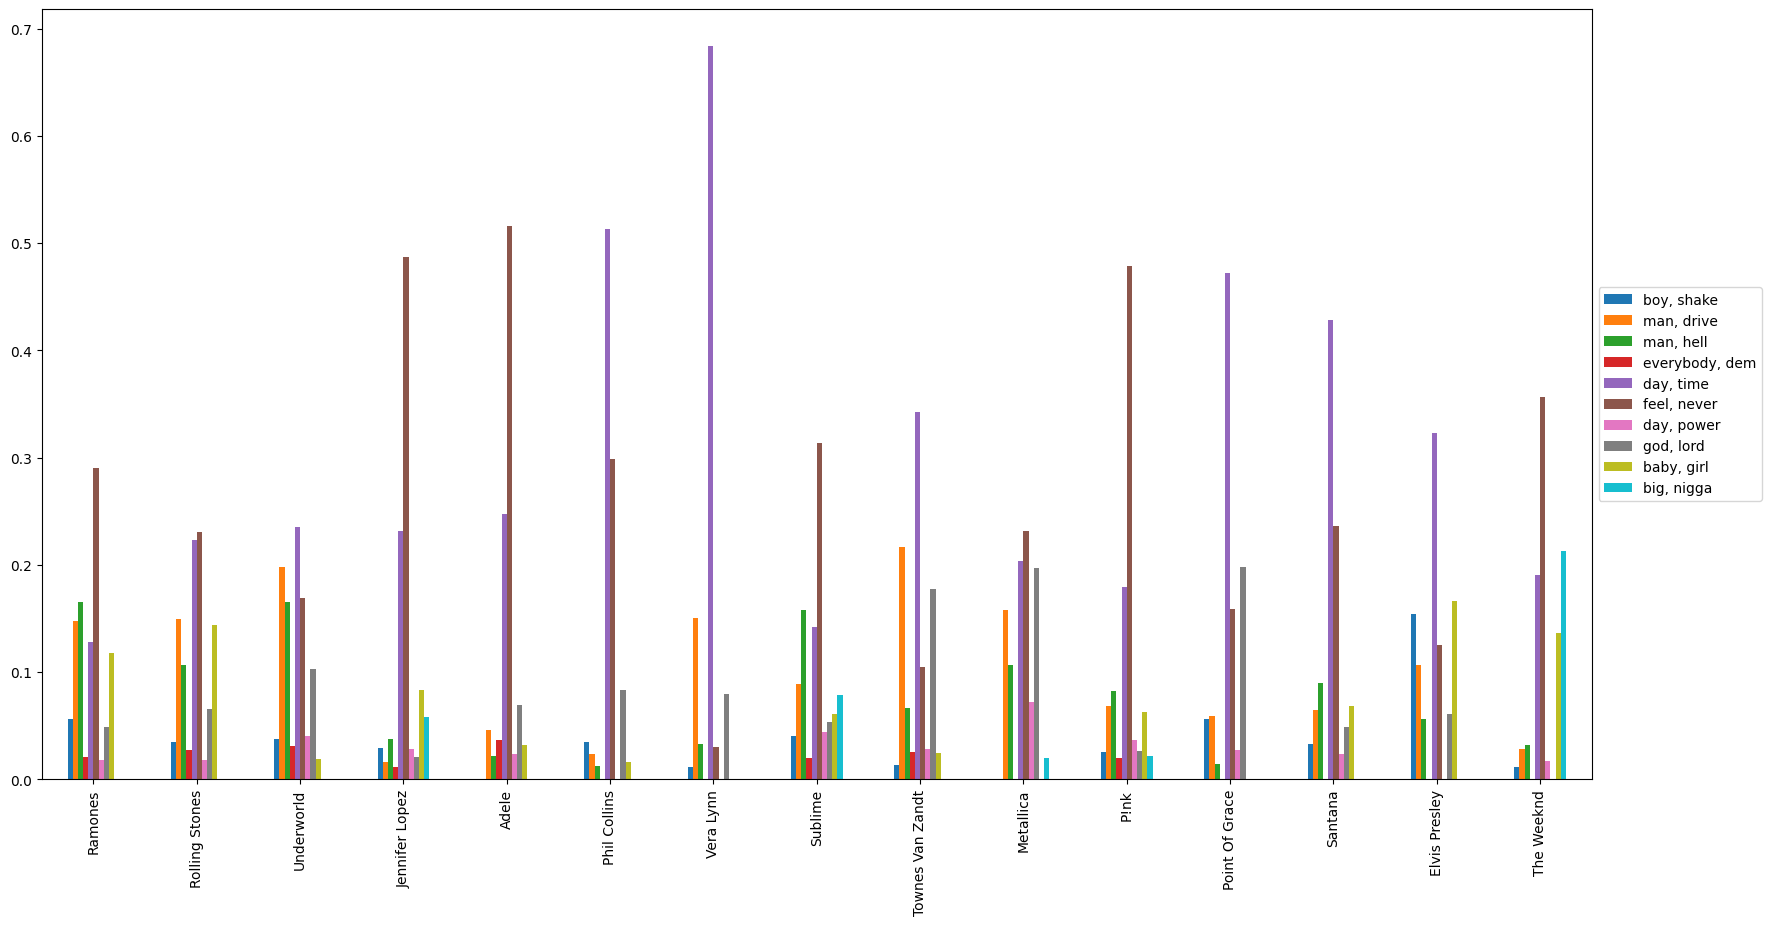

In [ ]:
# make a DataFrame
author_df = pd.DataFrame.from_dict(author_vecs)

# plot it
fig, ax = plt.subplots(figsize=(20,10))
author_df[target_authors[5:20]].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Let's visualise the proportions of topics for each artists with pie charts.

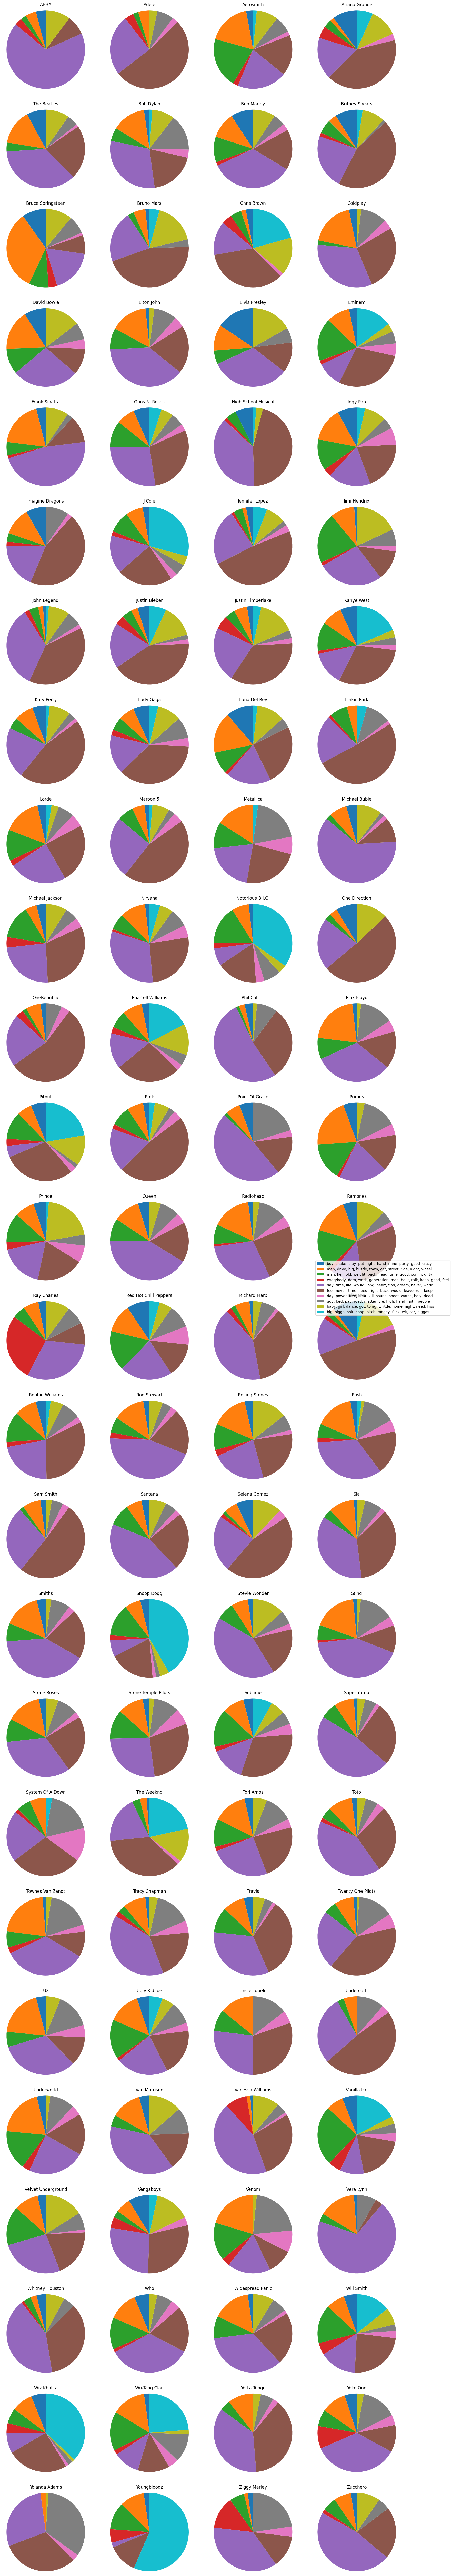

In [ ]:
topic_descriptors = [', '.join([word for word, _ in author_model.show_topic(topic)]) for topic in range(n_topics_author)]

topic_distributions = []
for author in author2doc.keys():
    author_topics = author_model.get_author_topics(author)
    topic_distribution = np.zeros(n_topics_author)
    for topic, weight in author_topics:
        topic_distribution[topic] += weight
    topic_distribution /= np.sum(topic_distribution)
    topic_distributions.append(topic_distribution)

n_rows = int(np.ceil(len(author2doc) / 4))
n_cols = min(len(author2doc), 4)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axs = axs.flatten()
for i, (author, doc_ids) in enumerate(author2doc.items()):
    axs[i].pie(topic_distributions[i], startangle=90)
    axs[i].set_title(f'{author}')
    axs[i].axis('equal')
fig.legend(topic_descriptors, loc="center right")
plt.show()

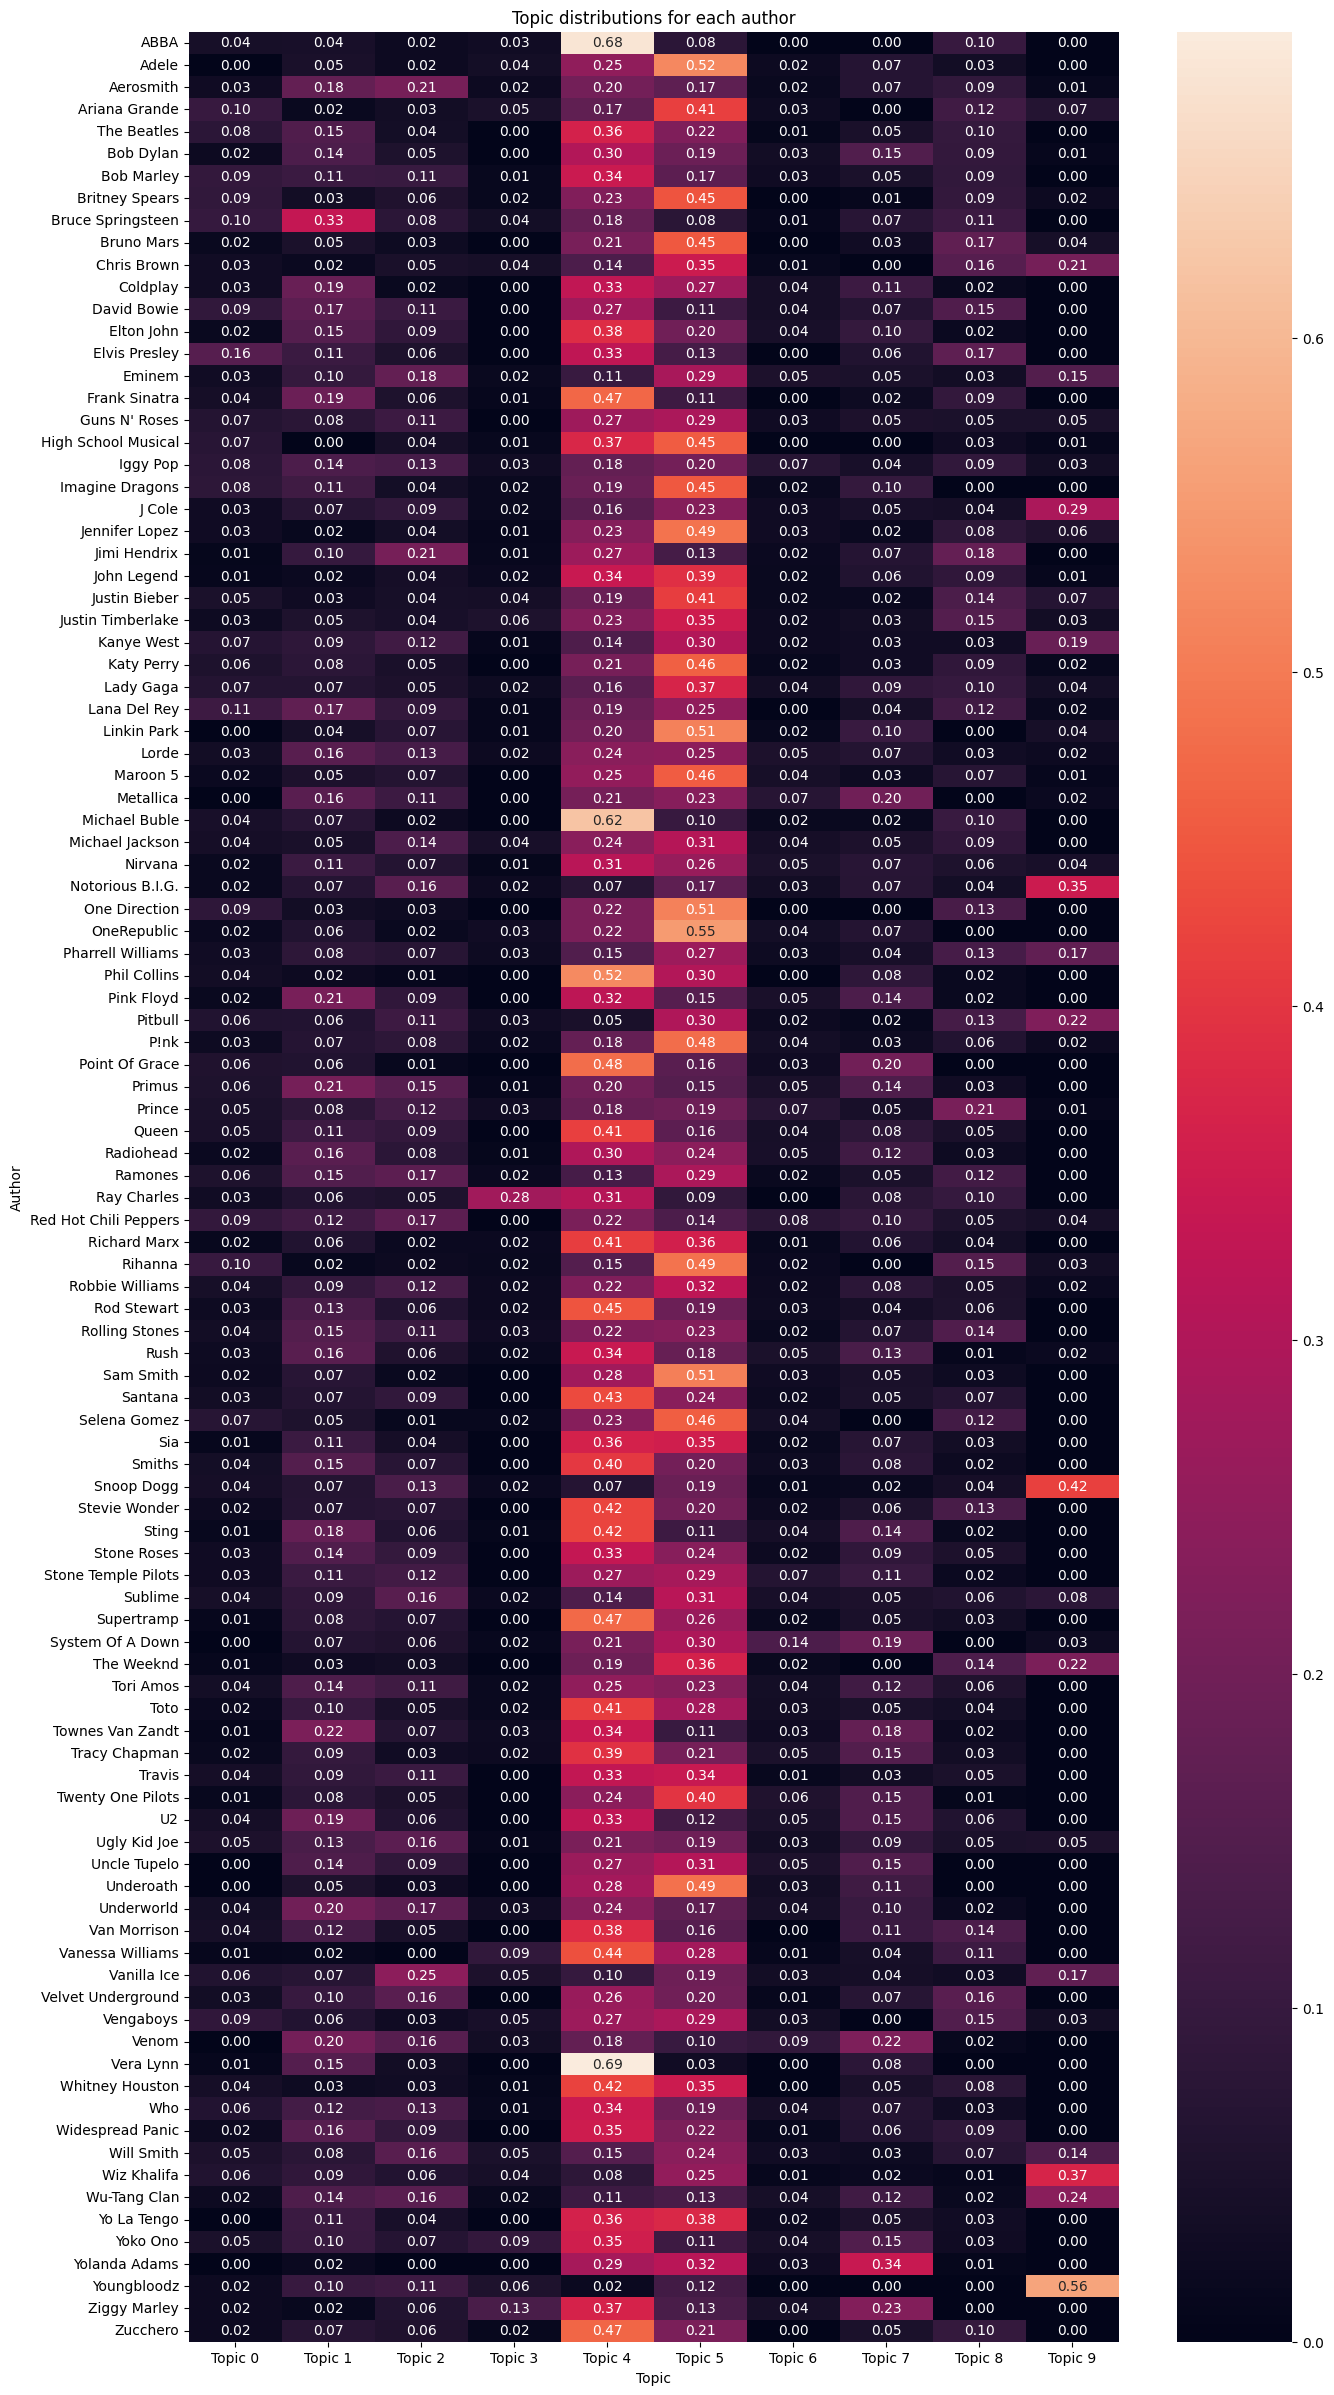

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# get the topic descriptors
topic_descriptors = [f"Topic {i}" for i in range(n_topics_author)]

# get the topic distributions for each author
topic_distributions = []
for author in author2doc.keys():
    author_topics = author_model.get_author_topics(author)
    topic_distribution = np.zeros(n_topics_author)
    for topic, weight in author_topics:
        topic_distribution[topic] += weight
    topic_distribution /= np.sum(topic_distribution)
    topic_distributions.append(topic_distribution)

# create a numpy array from the topic distributions
topic_array = np.array(topic_distributions)

# create the heatmap using seaborn
fig, ax = plt.subplots(figsize=(15, 30))
sns.heatmap(topic_array, annot=True, xticklabels=topic_descriptors, yticklabels=list(author2doc.keys()), fmt='.2f', ax=ax)

# set the axis labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('Author')
ax.set_title('Topic distributions for each author')

plt.show()

From this heatmap we can see that most artists share the topic 1 in their lyrics with a high percentage, compared to ohter topics. Since the cells of the heatmap represent the proportions or percentages of each topic for a particular artist, let's check transforming it in a Pandas DataFrame

In [ ]:
# Convert the topic array into a pandas DataFrame
df_heatmap = pd.DataFrame(topic_array, columns=topic_descriptors, index=list(author2doc.keys())).reset_index()
df_heatmap = df_heatmap.rename(columns={'index': 'Author'})

df_heatmap['Topic 1'].mean()

0.09936366818121269

In [ ]:
for i in range(0,10):
  print(df_heatmap[f'Topic {i}'].mean())

0.039347986762240904
0.09936366818121269
0.07992500429334923
0.02028354819176241
0.27976950854605187
0.2671666818815057
0.029187557230475183
0.07368360647356156
0.06630616681332774
0.04496627162651269


In [ ]:
df_heatmap

Author   Topic 0   Topic 1   Topic 2   Topic 3   Topic 4  \
0             ABBA  0.040585  0.044036  0.023719  0.030386  0.678632   
1            Adele  0.000000  0.046571  0.021637  0.036977  0.249124   
2        Aerosmith  0.028618  0.178189  0.208295  0.021668  0.204903   
3    Ariana Grande  0.100525  0.017244  0.034413  0.049461  0.172827   
4      The Beatles  0.078867  0.145159  0.036604  0.000000  0.362310   
..             ...       ...       ...       ...       ...       ...   
99        Yoko Ono  0.050327  0.103009  0.069218  0.093225  0.354461   
100  Yolanda Adams  0.000000  0.021557  0.000000  0.000000  0.286150   
101    Youngbloodz  0.023392  0.102057  0.112710  0.055889  0.019519   
102   Ziggy Marley  0.022075  0.015505  0.060937  0.133514  0.366441   
103       Zucchero  0.023989  0.071331  0.058414  0.015560  0.469345   

      Topic 5   Topic 6   Topic 7   Topic 8   Topic 9  
0    0.080033  0.000000  0.000000  0.102609  0.000000  
1    0.519955  0.023920  0.069368  0.032448  0.000000  
2    0.167681  0.017421  0.068854  0.089445  0.014927  
3    0.414646  0.026370  0.000000  0.117577  0.066937  
4    0.223076  0.010737  0.046254  0.096994  0.000000  
..        ...       ...       ...       ...       ...  
99   0.111864  0.042646  0.146604  0.028645  0.000000  
100  0.315993  0.027135  0.338379  0.010786  0.000000  
101  0.121464  0.000000  0.000000  0.000000  0.564969  
102  0.132642  0.041846  0.227042  0.000000  0.000000  
103  0.213791  0.000000  0.050752  0.096819  0.000000  

[104 rows x 11 columns]

In [ ]:
df_heatmap.to_csv('nlp_dataset_topics_fin.csv')

# Emotion Analysis
In this section we analyse the main emotion coming from artist's lyrics.

In [ ]:
df_e = pd.read_csv('nlp_dataset_prep.csv')
df_e=df_e.drop('Unnamed: 0', axis=1)
df_e

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  
0      look face wonderful face mean something specia...  
1      easy please touch gently like summer evening b...  
2      never know go put lousy rotten show boy tough ...  
3      make somebody happy question give learn show c...  
4      make somebody happy question give learn show c...  
...                                                  ...  
10072  want thank thing do want thank generosity neve...  
10073  seven rich country world little meeting plan k...  
10074  many generation pass away fighting fight today...  
10075  irie day come play let angel fly let devil die...  
10076  power worker power power worker need power pow...  

[10077 rows x 3 columns]

Let's remove the stop words excluding negativers because their presence affects sentiments. To do so, let's edit our preprocess() function in order to keep negativers when cleaning the text

In [ ]:
# Define a preprocess function
def preprocess_emotion(text):
    # extend contractions
    text = contractions.fix(text)
    # remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # lowercase the text
    text = text.lower()
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # remove stopwords
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    stop_words.remove('nor')
    stop_words.extend(['chorus', 'make', 'take'])
    text = ' '.join([w for w in text.split(' ') if w.lower() not in stop_words])
    # lemmatize the text
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    return text

In [ ]:
df_e['prep_text_emotion'] = df_e['text'].apply(preprocess_emotion)

Below we process the lyrics, in order to categorize them with the following emotions: Happiness, Anger, Sadness, Surprise, Fear. To do so, we will provide the output in the form of a dictionary thanks to text2motion

In [ ]:
df_e['emotions'] = [te.get_emotion(text) for text in df_e['prep_text_emotion']]
df_e

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  \
0      look face wonderful face mean something specia...   
1      easy please touch gently like summer evening b...   
2      never know go put lousy rotten show boy tough ...   
3      make somebody happy question give learn show c...   
4      make somebody happy question give learn show c...   
...                                                  ...   
10072  want thank thing do want thank generosity neve...   
10073  seven rich country world little meeting plan k...   
10074  many generation pass away fighting fight today...   
10075  irie day come play let angel fly let devil die...   
10076  power worker power power worker need power pow...   

                                       prep_text_emotion  \
0      look face wonderful face mean something specia...   
1      easy please touch gently like summer evening b...   
2      never know go put lousy rotten show boy tough ...   
3      make somebody happy question give learn show c...   
4      make somebody happy question give learn show c...   
...                                                  ...   
10072  want thank thing do want thank generosity neve...   
10073  seven rich country world little meeting plan k...   
10074  many generation pass away fighting fight today...   
10075  irie day come play let angel fly let devil die...   
10076  power worker power power worker need power pow...   

                                                emotions  
0      {'Happy': 0.42, 'Angry': 0.0, 'Surprise': 0.32...  
1      {'Happy': 0.28, 'Angry': 0.06, 'Surprise': 0.0...  
2      {'Happy': 0.29, 'Angry': 0.25, 'Surprise': 0.1...  
3      {'Happy': 0.54, 'Angry': 0.08, 'Surprise': 0.0...  
4      {'Happy': 0.54, 'Angry': 0.08, 'Surprise': 0.0...  
...                                                  ...  
10072  {'Happy': 0.37, 'Angry': 0.0, 'Surprise': 0.11...  
10073  {'Happy': 0.5, 'Angry': 0.06, 'Surprise': 0.06...  
10074  {'Happy': 0.1, 'Angry': 0.14, 'Surprise': 0.14...  
10075  {'Happy': 0.35, 'Angry': 0.0, 'Surprise': 0.25...  
10076  {'Happy': 0.14, 'Angry': 0.3, 'Surprise': 0.07...  

[10077 rows x 5 columns]

In [ ]:
def get_top_two_emotions(d):
   # sorting the dictionary items by score in descending order and extract the top 2 emotions
   top_two = sorted(d.items(), key=lambda x: x[1], reverse=True)[:2]
   # returning a comma-separated string of the two emotions
   return ', '.join([x[0] for x in top_two])

def get_top_emotion(d):
   # sorting the dictionary items by score in descending order and extract the top emotion
   top = sorted(d.items(), key=lambda x: x[1], reverse=True)[:1]
   # returning the emotion
   return [x[0] for x in top]

In [ ]:
# applying the function to the "emotions" column and create a new column with the results
df_e['TopEmotion'] = df_e['emotions'].apply(lambda x: get_top_emotion(x))

# applying the function to the "emotions" column and create a new column with the results
df_e['Top2Emotions'] = df_e['emotions'].apply(lambda x: get_top_two_emotions(x))

In [ ]:
df_e.to_csv('nlp_dataset_emotions.csv')

In [ ]:
import pandas as pd
df_e = pd.read_csv('nlp_dataset_emotions.csv')

In [ ]:
df_e[(df_e['artist'] == 'Eminem') & (df_e['Top2Emotions'].str.contains('Angry'))].head()

artist                                               text  \
862   Eminem  [Intro:]  \r\nThe poor stay poor, the rich get...   
866   Eminem  You are now listening to the sounds of...Shady...   
876   Eminem  [Intro:]  \r\nYeah, yeah, I get it  \r\nI run ...   
5517  Eminem  [Police voice]  \r\nAttention all units, atten...   
5519  Eminem  [Dj scratching] - "Do it!"  \r\n  \r\n[Eminem]...   

                                              prep_text  \
862   intro poor stay poor rich get rich disproporti...   
866   listen sounds ofshady andalchemistalchemistalc...   
876   intro yeah yeah get run rap shit guess back th...   
5517  police voice attention unit attention unit poi...   
5519  dj scratch eminem sneakin back door fruity mcs...   

                                      prep_text_emotion  \
862   intro poor stay poor rich get rich disproporti...   
866   listen sounds ofshady andalchemistalchemistalc...   
876   intro yeah yeah get run rap shit guess back th...   
5517  police voice attention unit attention unit poi...   
5519  dj scratch eminem sneakin back door fruity mcs...   

                                               emotions TopEmotion  \
862   {'Happy': 0.11, 'Angry': 0.22, 'Surprise': 0.1...     [Fear]   
866   {'Happy': 0.24, 'Angry': 0.24, 'Surprise': 0.1...    [Happy]   
876   {'Happy': 0.05, 'Angry': 0.24, 'Surprise': 0.1...     [Fear]   
5517  {'Happy': 0.18, 'Angry': 0.19, 'Surprise': 0.1...     [Fear]   
5519  {'Happy': 0.06, 'Angry': 0.18, 'Surprise': 0.1...     [Fear]   

      Top2Emotions TopEmotion_str  word_count  
862    Fear, Angry           Fear         347  
866   Happy, Angry          Happy         136  
876    Fear, Angry           Fear         157  
5517   Fear, Angry           Fear         318  
5519   Fear, Angry           Fear         242

In [ ]:
df_e2 = df_e.copy()
df_e2['emotions'] = df_e2['emotions'].apply(ast.literal_eval)

df_e2['Happy'] = df_e2['emotions'].apply(lambda x: x.get('Happy'))
df_e2['Angry'] = df_e2['emotions'].apply(lambda x: x.get('Angry'))
df_e2['Surprise'] = df_e2['emotions'].apply(lambda x: x.get('Surprise'))
df_e2['Sad'] = df_e2['emotions'].apply(lambda x: x.get('Sad'))
df_e2['Fear'] = df_e2['emotions'].apply(lambda x: x.get('Fear'))

Let us know visualize the proportion of emotions for each artist

In [ ]:
# Groupby artist and calculate the mean proportion of each emotion
grouped_data = df_e2.groupby(df_e['artist']).mean().reset_index()

df_proportions = grouped_data[['artist', 'Happy', 'Sad', 'Fear', 'Surprise', 'Angry']]

<ipython-input-58-5c150bfbe507>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df_e2.groupby(df_e['artist']).mean().reset_index()


In [ ]:
df_proportions

artist     Happy       Sad      Fear  Surprise     Angry
0             ABBA  0.223274  0.224956  0.281858  0.173805  0.087080
1            Adele  0.168889  0.322037  0.235000  0.165741  0.108704
2        Aerosmith  0.191930  0.254327  0.246433  0.182339  0.124269
3    Ariana Grande  0.203725  0.304510  0.195686  0.155294  0.140588
4        Bob Dylan  0.168191  0.276968  0.270638  0.167660  0.116117
..             ...       ...       ...       ...       ...       ...
99        Yoko Ono  0.156353  0.273294  0.266000  0.209647  0.094588
100  Yolanda Adams  0.230000  0.241458  0.312083  0.146458  0.069792
101    Youngbloodz  0.104211  0.235263  0.262632  0.263684  0.132632
102   Ziggy Marley  0.206406  0.245156  0.285469  0.164844  0.098437
103       Zucchero  0.179333  0.270667  0.240333  0.234333  0.042000

[104 rows x 6 columns]

In [ ]:
df_proportions.to_csv('nlp_proportions1.csv')

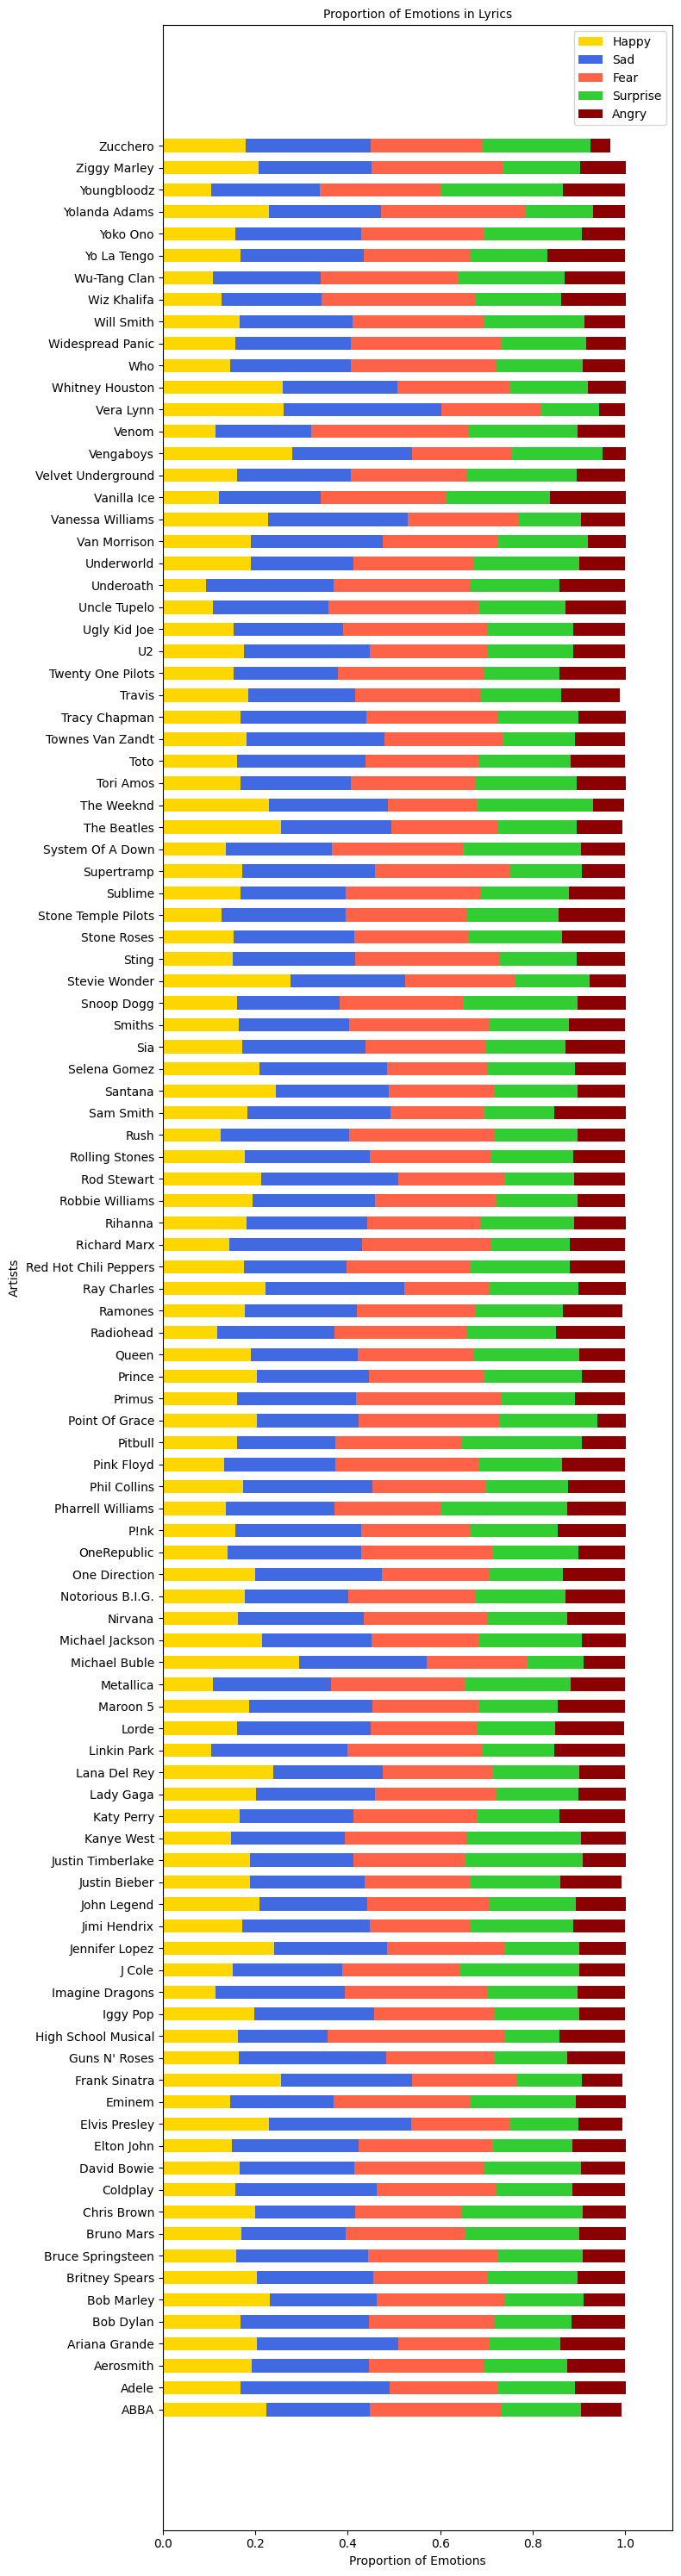

In [ ]:
# Plotting the proportion of emotions for each artist
x = np.arange(len(df_proportions['artist']))
width = 0.6  #adjust the width of the bars
fig, ax = plt.subplots(figsize=(8, 30))

emotions = ['Happy', 'Sad', 'Fear', 'Surprise', 'Angry']
colors = ['#FFD700', '#4169E1', '#FF6347', '#32CD32', '#8B0000']
bottom = np.zeros(len(df_proportions['artist']))

for emotion, color in zip(emotions, colors):
    rects = ax.barh(x, df_proportions[emotion], width, left=bottom, label=emotion, color=color)
    bottom += np.array(df_proportions[emotion])  # Update the bottom position for the next emotion

ax.set_xlabel('Proportion of Emotions', fontsize=10)
ax.set_ylabel('Artists', fontsize=10)
ax.set_title('Proportion of Emotions in Lyrics', fontsize=10)
ax.set_yticks(x)
ax.set_yticklabels(df_proportions['artist'], rotation=0)
ax.legend(fontsize=10)

ax.legend(loc='upper right')

fig.tight_layout()
ax.margins(x=0.1)
plt.subplots_adjust(wspace=0.3)

In [ ]:
df_e['TopEmotion_str'] = df_e['TopEmotion'].apply(lambda x: ','.join(x))
result_e = df_e.groupby('artist')['TopEmotion_str'].apply(lambda x: x.mode()[0])
result_e

artist
ABBA                 Fear
Adele                 Sad
Aerosmith             Sad
Ariana Grande         Sad
Bob Dylan             Sad
                   ...   
Yoko Ono              Sad
Yolanda Adams        Fear
Youngbloodz      Surprise
Ziggy Marley         Fear
Zucchero              Sad
Name: TopEmotion_str, Length: 104, dtype: object

In [ ]:
result_e2 = df_e.groupby('artist')['Top2Emotions'].apply(lambda x: x.mode()[0:1])
result_e2

artist          
ABBA           0       Fear, Happy
Adele          0     Sad, Surprise
Aerosmith      0         Sad, Fear
Ariana Grande  0         Sad, Fear
Bob Dylan      0         Sad, Fear
                         ...      
Yoko Ono       0         Sad, Fear
Yolanda Adams  0    Fear, Surprise
Youngbloodz    0    Fear, Surprise
Ziggy Marley   0         Sad, Fear
Zucchero       0         Sad, Fear
Name: Top2Emotions, Length: 104, dtype: object

Some further analysis just for fun:
maybe, we would expect an angry text to be lengthier than a happy one? (ie. emotionally charged messages often require more words to express the feelings accurately. When we're upset or angry, we tend to be more expressive and detailed in our communication, using more words to convey our emotions and thoughts.).
Let's see check correlations between primary emotion in a lyrics and its lenght:

In [ ]:
# Calculate correlation between each emotion and text length
correlation_results = df_e.groupby('TopEmotion')['text'].apply(lambda x: x.str.len().corr(pd.Series(x.index))).reset_index()
correlation_results.columns = ['Emotion', 'Correlation with Text Length']

# Sort the results by correlation coefficient
correlation_results = correlation_results.sort_values('Correlation with Text Length', ascending=False)

print(correlation_results)

        Emotion  Correlation with Text Length
4  ['Surprise']                      0.113248
0     ['Angry']                      0.035783
2     ['Happy']                      0.034377
3       ['Sad']                     -0.031380
1      ['Fear']                     -0.076845


'Surprise' shows the highest positive correlation with the text length. This suggests that when expressing surprise, artists may use more words to convey the unexpected or astonishing elements.
'Sad' exhibits a slightly negative correlation with text length.This observation aligns with the idea that when experiencing sadness, songwriters may express their emotions concisely, using fewer words to convey the depth of their feelings.
'Angry' and 'Happy' show positive correlations, albeit weaker compared to 'Surprise.'
'Fear' demonstrates a negative correlation with the text length. This observation could be attributed to the desire to convey a sense of urgency or intensity by using concise and impactful wording.

# Vocabulary Richness



To estimate the vocabulary richness and further using it as a feature, we check how many unique words were used in each lyric (by taking into account the already pre-processed text)

In [ ]:
import pandas as pd
df_v = pd.read_csv('nlp_dataset_prep.csv')
df_v = df_v.drop('Unnamed: 0', axis=1)
df_v.head()

artist                                               text  \
0   ABBA  Look at her face, it's a wonderful face  \r\nA...   
1   ABBA  Take it easy with me, please  \r\nTouch me gen...   
2   ABBA  I'll never know why I had to go  \r\nWhy I had...   
3   ABBA  Making somebody happy is a question of give an...   
4   ABBA  Making somebody happy is a question of give an...   

                                           prep_text  
0  look face wonderful face mean something specia...  
1  easy please touch gently like summer evening b...  
2  never know go put lousy rotten show boy tough ...  
3  make somebody happy question give learn show c...  
4  make somebody happy question give learn show c...

Let's remove duplicates

In [ ]:
df_v['prep_text'] = df_v['prep_text'].apply(lambda x: set(x.split()))
df_v

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  
0      {plan, special, talk, girl, mean, could, leave...  
1      {summer, away, music, slowly, talk, eye, eveni...  
2      {new, intention, use, stand, well, darling, mi...  
3      {care, come, away, return, surrender, anywhere...  
4      {care, come, away, return, surrender, anywhere...  
...                                                  ...  
10072  {alone, talk, still, never, hey, real, want, d...  
10073  {plan, well, write, small, fashion, homeless, ...  
10074  {come, away, kid, weep, pass, dangerous, well,...  
10075  {future, come, die, five, remember, use, grand...  
10076  {worker, cry, string, talk, can, wing, thema, ...  

[10077 rows x 3 columns]

Now, for each lyric let's check how many different words have been used

In [ ]:
df_v['richness_words'] = df_v['prep_text'].apply(len)
df_v

artist                                               text  \
0              ABBA  Look at her face, it's a wonderful face  \r\nA...   
1              ABBA  Take it easy with me, please  \r\nTouch me gen...   
2              ABBA  I'll never know why I had to go  \r\nWhy I had...   
3              ABBA  Making somebody happy is a question of give an...   
4              ABBA  Making somebody happy is a question of give an...   
...             ...                                                ...   
10072  Ziggy Marley  [Chorus]  \r\nI wanna thank you for the things...   
10073  Ziggy Marley  Seven richest countries in the world  \r\nThem...   
10074  Ziggy Marley  Many generation have passed away  \r\nFighting...   
10075  Ziggy Marley  Irie days come on play  \r\nLet the angels fly...   
10076  Ziggy Marley  Power to the workers  \r\nMore power  \r\nPowe...   

                                               prep_text  richness_words  
0      {plan, special, talk, girl, mean, could, leave...              34  
1      {summer, away, music, slowly, talk, eye, eveni...              42  
2      {new, intention, use, stand, well, darling, mi...              61  
3      {care, come, away, return, surrender, anywhere...              55  
4      {care, come, away, return, surrender, anywhere...              55  
...                                                  ...             ...  
10072  {alone, talk, still, never, hey, real, want, d...              33  
10073  {plan, well, write, small, fashion, homeless, ...              59  
10074  {come, away, kid, weep, pass, dangerous, well,...              69  
10075  {future, come, die, five, remember, use, grand...              56  
10076  {worker, cry, string, talk, can, wing, thema, ...             123  

[10077 rows x 4 columns]

And now we groupby artist and get the mean value of different words used in their lyrics

In [ ]:
df_v_grouped = df_v.groupby(['artist']).mean('richness_words')

In [ ]:
df_v_grouped.sort_values('richness_words', ascending = False)

richness_words
artist                          
Wu-Tang Clan          217.792453
Eminem                172.742857
Youngbloodz           171.947368
Notorious B.I.G.      171.880000
Snoop Dogg            163.901408
...                          ...
Vera Lynn              37.250000
Ramones                36.883721
Radiohead              36.160000
The Beatles            36.112360
Nirvana                35.553398

[104 rows x 1 columns]

Wu-Tang Clan has the highest average richness with 217.79 unique words, indicating a wide vocabulary range in their songs. This can be due to the fact that the group is composed of multiple members with unique styles and backgrounds (they also do solos), bringing together a range of perspectives and experiences and resulting in a diverse vocabulary usage.

 Eminem, Youngbloodz, Notorious B.I.G., and Snoop Dogg also have relatively high values, suggesting a diverse vocabulary in their lyrics. These artists are known for their lyrical prowess and storytelling abilities, which require a diverse vocabulary to effectively convey their messages.

 On the other hand, artists like Vera Lynn, Ramones, Radiohead, The Beatles, and Nirvana have lower average richness values. This can be explained by the fact that their music often emphasizes other aspects such as melody, rhythm, and thematic depth, rather than relying heavily on intricate wordplay or complex lyrical structures.

# Clustering



Using the information gathered so far, we now proceed to divide the artists into a few different groups, based on the percentage of each topic in their texts and the percentage of emotions captured by our model. What we expect to obtain, is a division of the authors based on certain genres. To do this, we will use the kmeans algorithm as a clustering technique.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from google.colab import files

In [ ]:
df_topic = pd.read_csv('nlp_dataset_topics_fin.csv')
df_perc = pd.read_csv('nlp_proportions1.csv')
df_sent = pd.read_csv('nlp_proportions0.csv')

In [ ]:
df = pd.merge(df_topic, df_perc, left_on='Author', right_on='artist')
df = df.drop(['Unnamed: 0_x','Unnamed: 0_y', 'artist'], axis=1)
df = pd.merge(df, df_sent, left_on='Author', right_on='artist')
df = df.drop(['Unnamed: 0', 'artist'], axis=1)
df.columns

Index(['Author', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4',
       'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Happy', 'Sad',
       'Fear', 'Surprise', 'Angry', 'sentiment_score'],
      dtype='object')

In [ ]:
nume = list(set(["Topic 0", "Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7", "Topic 8", "Topic 9",
"Happy", "Angry", "Surprise", "Sad", "Fear", "sentiment_score"]))
features = df[nume]
features

Happy   Topic 6   Topic 1   Topic 9       Sad   Topic 0   Topic 4  \
0    0.223274  0.000000  0.044036  0.000000  0.224956  0.040585  0.678632   
1    0.168889  0.023920  0.046571  0.000000  0.322037  0.000000  0.249124   
2    0.191930  0.017421  0.178189  0.014927  0.254327  0.028618  0.204903   
3    0.203725  0.026370  0.017244  0.066937  0.304510  0.100525  0.172827   
4    0.255169  0.010737  0.145159  0.000000  0.239831  0.078867  0.362310   
..        ...       ...       ...       ...       ...       ...       ...   
99   0.156353  0.042646  0.103009  0.000000  0.273294  0.050327  0.354461   
100  0.230000  0.027135  0.021557  0.000000  0.241458  0.000000  0.286150   
101  0.104211  0.000000  0.102057  0.564969  0.235263  0.023392  0.019519   
102  0.206406  0.041846  0.015505  0.000000  0.245156  0.022075  0.366441   
103  0.179333  0.000000  0.071331  0.000000  0.270667  0.023989  0.469345   

         Fear  sentiment_score   Topic 7   Topic 2   Topic 3   Topic 5  \
0    0.281858         0.565476  0.000000  0.023719  0.030386  0.080033   
1    0.235000         0.430700  0.069368  0.021637  0.036977  0.519955   
2    0.246433         0.489203  0.068854  0.208295  0.021668  0.167681   
3    0.195686         0.644716  0.000000  0.034413  0.049461  0.414646   
4    0.227921         0.586339  0.046254  0.036604  0.000000  0.223076   
..        ...              ...       ...       ...       ...       ...   
99   0.266000         0.302902  0.146604  0.069218  0.093225  0.111864   
100  0.312083         0.795200  0.338379  0.000000  0.000000  0.315993   
101  0.262632        -0.713521  0.000000  0.112710  0.055889  0.121464   
102  0.285469         0.491231  0.227042  0.060937  0.133514  0.132642   
103  0.240333         0.395100  0.050752  0.058414  0.015560  0.213791   

     Surprise     Angry   Topic 8  
0    0.173805  0.087080  0.102609  
1    0.165741  0.108704  0.032448  
2    0.182339  0.124269  0.089445  
3    0.155294  0.140588  0.117577  
4    0.171742  0.098652  0.096994  
..        ...       ...       ...  
99   0.209647  0.094588  0.028645  
100  0.146458  0.069792  0.010786  
101  0.263684  0.132632  0.000000  
102  0.164844  0.098437  0.000000  
103  0.234333  0.042000  0.096819  

[104 rows x 16 columns]

In order to obtain less noisy data, we decided to standardize our features (using a simple standard scaler) and to fill potential empty values.To do so we use the K Nearest Neighbors Imputer.

In [ ]:
scaler = StandardScaler()
imputer = KNNImputer()

filled_features = imputer.fit_transform(features)
scaled_features = scaler.fit_transform(filled_features)

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

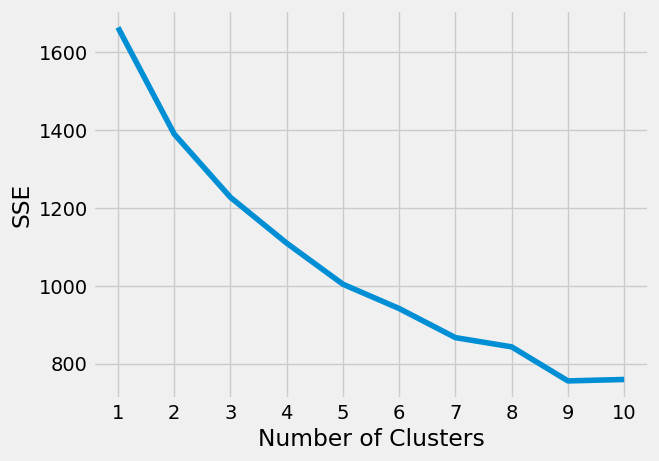

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig("sse.png", bbox_inches='tight')
files.download("sse.png")
plt.show()

The plot of the SSE (Sum of Squared Errors) doesn't display a clear 'elbow', indicating a precise point after which the errors start decreasing significantly less. However we can claim that for sure after 9 clusters there is no decrease. We now want to look at the silhouette coefficients for each value to check if 9 is a good choice for our model, also relying on the fact that for our purpose, the number of music genres in real life shouldn't be too small.

In [ ]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

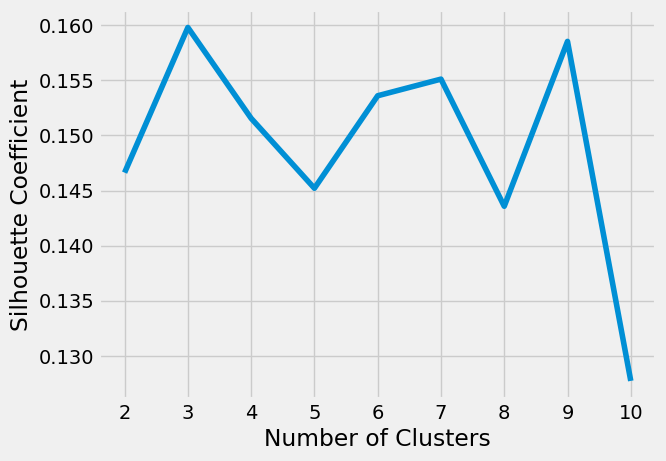

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.savefig("silhouette.png", bbox_inches='tight')
files.download("silhouette.png")
plt.show()

In [ ]:
kmeans = KMeans(
     init="random",
     n_clusters=9,
     n_init=20,
     max_iter=300,
     random_state=42
 )

In [ ]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=9, n_init=20, random_state=42)

In [ ]:
print(kmeans.cluster_centers_)
print(kmeans.n_iter_)

In [ ]:
lab = kmeans.labels_
unique, counts = np.unique(lab, return_counts=True)
dict(zip(unique, counts))

{0: 1, 1: 14, 2: 24, 3: 10, 4: 8, 5: 8, 6: 13, 7: 16, 8: 10}

Having run the model with the selected number of clusters, we now proceed to the visualisation and analysis of the clusters obtained. Later we will also check their conformity with real data.

In [ ]:
cl0 = []
cl1 = []
cl2 = []
cl3 = []
cl4 = []
cl5 = []
cl6 = []
cl7 = []
cl8 = []
for i in range(len(lab)):
  if lab[i] == 0:
    cl0.append(df['Author'][i])
  elif lab[i] == 1:
    cl1.append(df['Author'][i])
  elif lab[i] == 2:
    cl2.append(df['Author'][i])
  elif lab[i] == 3:
    cl3.append(df['Author'][i])
  elif lab[i] == 4:
    cl4.append(df['Author'][i])
  elif lab[i] == 5:
    cl5.append(df['Author'][i])
  elif lab[i] == 6:
    cl6.append(df['Author'][i])
  elif lab[i] == 7:
    cl7.append(df['Author'][i])
  elif lab[i] == 8:
    cl8.append(df['Author'][i])

print('Cluster 1: ' + str(cl0))
print('Cluster 2: ' + str(cl1))
print('Cluster 3: ' + str(cl2))
print('Cluster 4: ' + str(cl3))
print('Cluster 5: ' + str(cl4))
print('Cluster 6: ' + str(cl5))
print('Cluster 7: ' + str(cl6))
print('Cluster 8: ' + str(cl7))
print('Cluster 9: ' + str(cl8))

Cluster 1: ['Ray Charles']
Cluster 2: ['Bob Dylan', 'Coldplay', 'Elton John', 'Point Of Grace', 'Rush', 'Smiths', 'Sting', 'Supertramp', 'Townes Van Zandt', 'Tracy Chapman', 'U2', 'Yoko Ono', 'Yolanda Adams', 'Ziggy Marley']
Cluster 3: ['Aerosmith', 'Bob Marley', 'Bruce Springsteen', 'David Bowie', 'Iggy Pop', 'Jimi Hendrix', 'Lana Del Rey', 'Primus', 'Prince', 'Queen', 'Ramones', 'Red Hot Chili Peppers', 'Robbie Williams', 'Rolling Stones', 'Stone Roses', 'Sublime', 'Tori Amos', 'Travis', 'Ugly Kid Joe', 'Underworld', 'Velvet Underground', 'Who', 'Widespread Panic', 'Will Smith']
Cluster 4: ['Ariana Grande', 'Britney Spears', 'High School Musical', 'Jennifer Lopez', 'Justin Bieber', 'Katy Perry', 'Lady Gaga', 'One Direction', 'Rihanna', 'Selena Gomez']
Cluster 5: ['Metallica', 'Pink Floyd', 'Radiohead', 'Stone Temple Pilots', 'System Of A Down', 'Twenty One Pilots', 'Uncle Tupelo', 'Venom']
Cluster 6: ['Bruno Mars', 'Chris Brown', 'John Legend', 'Justin Timberlake', 'Michael Jackson',

First we want to explore some basic statistics to check which are the main differences between the clusters obtained, looking at the mean distribution of the topics and at the mean scores of the emotions analysis.

In [ ]:
df.cluster = lab

<ipython-input-15-51f1aca3b357>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cluster = lab


In [ ]:
df[df.cluster==0].describe()[nume]

Happy  Topic 6  Topic 1  Topic 9       Sad   Topic 0   Topic 4  \
count  1.000000      1.0  1.00000      1.0  1.000000  1.000000  1.000000   
mean   0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   
std         NaN      NaN      NaN      NaN       NaN       NaN       NaN   
min    0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   
25%    0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   
50%    0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   
75%    0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   
max    0.221976      0.0  0.06314      0.0  0.299641  0.030797  0.308909   

           Fear  sentiment_score  Topic 7   Topic 2   Topic 3   Topic 5  \
count  1.000000         1.000000  1.00000  1.000000  1.000000  1.000000   
mean   0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   
std         NaN              NaN      NaN       NaN       NaN       NaN   
min    0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   
25%    0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   
50%    0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   
75%    0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   
max    0.182455         0.586839  0.07634  0.054037  0.276082  0.090859   

       Surprise     Angry   Topic 8  
count  1.000000  1.000000  1.000000  
mean   0.194072  0.101976  0.099835  
std         NaN       NaN       NaN  
min    0.194072  0.101976  0.099835  
25%    0.194072  0.101976  0.099835  
50%    0.194072  0.101976  0.099835  
75%    0.194072  0.101976  0.099835  
max    0.194072  0.101976  0.099835

In [ ]:
df[df.cluster==1].describe()[nume]

Happy    Topic 6    Topic 1    Topic 9        Sad    Topic 0  \
count  14.000000  14.000000  14.000000  14.000000  14.000000  14.000000   
mean    0.172073   0.036682   0.125492   0.002237   0.267434   0.025811   
std     0.026921   0.010451   0.063871   0.005900   0.023620   0.015891   
min     0.125086   0.016256   0.015505   0.000000   0.220265   0.000000   
25%     0.156536   0.027520   0.085210   0.000000   0.250312   0.015216   
50%     0.168486   0.038349   0.145209   0.000000   0.272474   0.022183   
75%     0.180318   0.044023   0.174755   0.000000   0.277271   0.036057   
max     0.230000   0.050635   0.217214   0.019673   0.304667   0.057030   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  14.000000  14.000000        14.000000  14.000000  14.000000  14.000000   
mean    0.372119   0.285815         0.431050   0.153067   0.051851   0.021576   
std     0.058448   0.021837         0.165452   0.070852   0.025783   0.040705   
min     0.286150   0.255222         0.207249   0.047674   0.000000   0.000000   
25%     0.330828   0.267160         0.311179   0.115214   0.036304   0.000000   
50%     0.360451   0.287249         0.426802   0.146158   0.061604   0.000000   
75%     0.401861   0.304109         0.478691   0.171112   0.067371   0.020887   
max     0.479392   0.315314         0.795200   0.338379   0.087179   0.133514   

         Topic 5   Surprise      Angry    Topic 8  
count  14.000000  14.000000  14.000000  14.000000  
mean    0.184244   0.173589   0.100924   0.026921  
std     0.066016   0.018231   0.017235   0.024565  
min     0.105074   0.146458   0.061327   0.000000  
25%     0.122406   0.165154   0.095551   0.013179  
50%     0.187057   0.169949   0.103456   0.021622  
75%     0.206843   0.177857   0.114189   0.033050  
max     0.315993   0.211239   0.120746   0.093134

In [ ]:
df[df.cluster==2].describe()[nume]

Happy    Topic 6    Topic 1    Topic 9        Sad    Topic 0  \
count  24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean    0.178452   0.032089   0.139645   0.017290   0.247449   0.053960   
std     0.023397   0.019791   0.054722   0.033661   0.016856   0.026957   
min     0.146687   0.000000   0.076997   0.000000   0.221387   0.010417   
25%     0.160841   0.017740   0.100636   0.000000   0.235025   0.035304   
50%     0.174615   0.028802   0.136344   0.000000   0.245688   0.048748   
75%     0.190848   0.041146   0.158568   0.018248   0.258996   0.066921   
max     0.239027   0.076120   0.332383   0.142093   0.286229   0.112602   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  24.000000  24.000000        24.000000  24.000000  24.000000  24.000000   
mean    0.243184   0.269801         0.429326   0.070546   0.133586   0.016140   
std     0.075620   0.026653         0.140040   0.027062   0.036583   0.013651   
min     0.128570   0.215669         0.194663   0.026663   0.081002   0.000000   
25%     0.185572   0.249688         0.315502   0.049981   0.105384   0.000000   
50%     0.223402   0.265087         0.400072   0.069337   0.126364   0.014454   
75%     0.288404   0.281231         0.525702   0.083647   0.161127   0.023327   
max     0.414526   0.324300         0.692827   0.142922   0.209114   0.049453   

         Topic 5   Surprise      Angry    Topic 8  
count  24.000000  24.000000  24.000000  24.000000  
mean    0.205116   0.197195   0.105878   0.088444  
std     0.066604   0.021571   0.014106   0.050733  
min     0.076934   0.160843   0.085800   0.018972  
25%     0.166470   0.182023   0.093972   0.051261  
50%     0.196677   0.188584   0.104263   0.078461  
75%     0.237701   0.215995   0.113785   0.118038  
max     0.337750   0.239167   0.134865   0.210755

In [ ]:
df[df.cluster==3].describe()[nume]

Happy    Topic 6    Topic 1    Topic 9        Sad    Topic 0  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.195690   0.017832   0.034473   0.031615   0.255621   0.072281   
std     0.022945   0.013998   0.024950   0.025913   0.028289   0.023089   
min     0.161667   0.000000   0.000000   0.000000   0.195000   0.028841   
25%     0.182404   0.003791   0.016352   0.013896   0.246022   0.058447   
50%     0.200526   0.018964   0.030777   0.028428   0.254227   0.072457   
75%     0.203664   0.027433   0.049657   0.052209   0.270773   0.088902   
max     0.241636   0.036020   0.078827   0.069805   0.304510   0.100525   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  10.000000  10.000000        10.000000  10.000000  10.000000  10.000000   
mean    0.216639   0.253111         0.611115   0.016810   0.037741   0.018436   
std     0.062483   0.050182         0.041701   0.027143   0.013989   0.015583   
min     0.153865   0.195686         0.507987   0.000000   0.013743   0.000000   
25%     0.176464   0.229506         0.602604   0.000000   0.028023   0.011678   
50%     0.212758   0.244703         0.616645   0.005619   0.039485   0.015185   
75%     0.230160   0.261564         0.641708   0.020014   0.046051   0.022537   
max     0.373927   0.381111         0.647656   0.087517   0.058069   0.049461   

         Topic 5   Surprise      Angry    Topic 8  
count  10.000000  10.000000  10.000000  10.000000  
mean    0.449601   0.173168   0.121528   0.104572  
std     0.041745   0.025347   0.018042   0.035068  
min     0.369519   0.119444   0.099818   0.027399  
25%     0.422263   0.158682   0.105245   0.089221  
50%     0.455683   0.177262   0.121164   0.108165  
75%     0.480127   0.193654   0.139140   0.127562  
max     0.509426   0.203217   0.142778   0.151256

In [ ]:
df[df.cluster==4].describe()[nume]

Happy   Topic 6   Topic 1   Topic 9       Sad   Topic 0   Topic 4  \
count  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000   
mean   0.124878  0.071355  0.141364  0.005758  0.240912  0.010003  0.249119   
std    0.015246  0.030693  0.053577  0.010763  0.019690  0.011350  0.049057   
min    0.109161  0.045175  0.066595  0.000000  0.206556  0.000000  0.177479   
25%    0.112813  0.050743  0.099913  0.000000  0.227968  0.000000  0.211264   
50%    0.122443  0.062821  0.150865  0.000000  0.244985  0.006757  0.254134   
75%    0.133767  0.077087  0.171465  0.005072  0.254360  0.018982  0.275319   
max    0.152424  0.137873  0.211960  0.025778  0.267581  0.027534  0.323108   

           Fear  sentiment_score   Topic 7   Topic 2   Topic 3   Topic 5  \
count  8.000000         8.000000  8.000000  8.000000  8.000000  8.000000   
mean   0.301611        -0.131861  0.157182  0.093966  0.007416  0.252597   
std    0.024842         0.252612  0.040792  0.033888  0.012214  0.092221   
min    0.263387        -0.552090  0.105031  0.051591  0.000000  0.104109   
25%    0.285663        -0.318007  0.133043  0.075153  0.000000  0.214038   
50%    0.300297        -0.077554  0.145138  0.088723  0.000000  0.264005   
75%    0.318148         0.010266  0.190543  0.110916  0.011434  0.298026   
max    0.339222         0.218949  0.220046  0.156245  0.033854  0.399507   

       Surprise     Angry   Topic 8  
count  8.000000  8.000000  8.000000  
mean   0.204879  0.127558  0.011240  
std    0.030950  0.020263  0.010381  
min    0.162424  0.094776  0.000000  
25%    0.185948  0.114520  0.000000  
50%    0.195606  0.132988  0.012630  
75%    0.229696  0.144236  0.018444  
max    0.253284  0.149400  0.026575

In [ ]:
df[df.cluster==5].describe()[nume]

Happy   Topic 6   Topic 1   Topic 9       Sad   Topic 0   Topic 4  \
count  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000   
mean   0.203610  0.021056  0.045699  0.089508  0.235515  0.031505  0.221373   
std    0.042264  0.012340  0.022027  0.092154  0.015141  0.024547  0.066138   
min    0.137000  0.000000  0.019956  0.000000  0.216000  0.011242  0.138363   
25%    0.183964  0.015816  0.026179  0.027899  0.224815  0.015447  0.181809   
50%    0.204036  0.019315  0.048321  0.037321  0.234269  0.027584  0.219908   
75%    0.218963  0.027404  0.056882  0.181416  0.240599  0.033397  0.247740   
max    0.280000  0.039857  0.082770  0.216441  0.259231  0.087157  0.342204   

           Fear  sentiment_score   Topic 7   Topic 2   Topic 3   Topic 5  \
count  8.000000         8.000000  8.000000  8.000000  8.000000  8.000000   
mean   0.233291         0.544509  0.027960  0.053143  0.029255  0.346800   
std    0.021996         0.161788  0.025170  0.037508  0.021254  0.057785   
min    0.194138         0.220666  0.000000  0.025545  0.000000  0.268839   
25%    0.226952         0.468399  0.000000  0.031672  0.014763  0.306199   
50%    0.231949         0.587955  0.031994  0.040995  0.034760  0.348708   
75%    0.245107         0.673267  0.047015  0.052420  0.044070  0.369495   
max    0.261828         0.688583  0.061552  0.139109  0.055807  0.451135   

       Surprise     Angry   Topic 8  
count  8.000000  8.000000  8.000000  
mean   0.236292  0.091469  0.133701  
std    0.030648  0.023363  0.031286  
min    0.189140  0.049231  0.086927  
25%    0.215359  0.086530  0.118443  
50%    0.247298  0.093754  0.142286  
75%    0.256504  0.102498  0.153938  
max    0.272333  0.125333  0.172821

In [ ]:
df[df.cluster==6].describe()[nume]

Happy    Topic 6    Topic 1  Topic 9        Sad    Topic 0  \
count  13.000000  13.000000  13.000000     13.0  13.000000  13.000000   
mean    0.239348   0.008812   0.093511      0.0   0.274271   0.043540   
std     0.032874   0.010800   0.052985      0.0   0.032798   0.037903   
min     0.179333   0.000000   0.015353      0.0   0.224956   0.011516   
25%     0.223274   0.000000   0.065246      0.0   0.247312   0.023989   
50%     0.244369   0.000000   0.073336      0.0   0.277143   0.038106   
75%     0.260000   0.018189   0.131099      0.0   0.295674   0.043023   
max     0.294375   0.026283   0.191189      0.0   0.340833   0.155714   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  13.000000  13.000000        13.000000  13.000000  13.000000  13.000000   
mean    0.474126   0.234902         0.637341   0.048035   0.045628   0.014075   
std     0.116315   0.017966         0.111073   0.027119   0.024219   0.025151   
min     0.325485   0.213988         0.395100   0.000000   0.000000   0.000000   
25%     0.421087   0.226364         0.573073   0.039418   0.031127   0.000000   
50%     0.438450   0.231404         0.626123   0.047739   0.047505   0.000000   
75%     0.472013   0.240333         0.720706   0.056620   0.058414   0.015560   
max     0.691591   0.281858         0.834425   0.107965   0.090482   0.090361   

         Topic 5   Surprise      Angry    Topic 8  
count  13.000000  13.000000  13.000000  13.000000  
mean    0.176687   0.161654   0.084920   0.095584  
std     0.087382   0.030642   0.018541   0.041155  
min     0.030315   0.121429   0.042000   0.000000  
25%     0.111456   0.140260   0.081075   0.077961  
50%     0.189483   0.160935   0.087922   0.096994  
75%     0.223076   0.173805   0.095000   0.109710  
max     0.347844   0.234333   0.109270   0.167892

In [ ]:
df[df.cluster==7].describe()[nume]

Happy    Topic 6    Topic 1    Topic 9        Sad    Topic 0  \
count  16.000000  16.000000  16.000000  16.000000  16.000000  16.000000   
mean    0.153309   0.028467   0.078266   0.012094   0.285375   0.023305   
std     0.027634   0.013875   0.034509   0.018273   0.018181   0.023042   
min     0.093478   0.000000   0.023856   0.000000   0.265065   0.000000   
25%     0.142340   0.018414   0.053631   0.000000   0.272674   0.008861   
50%     0.161304   0.028101   0.071444   0.000000   0.279731   0.020571   
75%     0.169816   0.035979   0.105868   0.022343   0.291508   0.027948   
max     0.187455   0.052807   0.157409   0.049755   0.322037   0.081632   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  16.000000  16.000000        16.000000  16.000000  16.000000  16.000000   
mean    0.296594   0.254381         0.284979   0.066841   0.050426   0.011917   
std     0.095717   0.029751         0.209754   0.024795   0.034597   0.012599   
min     0.178824   0.203000        -0.176018   0.025846   0.012254   0.000000   
25%     0.233142   0.232115         0.162991   0.052674   0.021078   0.000000   
50%     0.274833   0.244231         0.314156   0.066667   0.040694   0.011078   
75%     0.363104   0.278827         0.400426   0.077289   0.069014   0.020095   
max     0.523152   0.309512         0.686653   0.114767   0.127482   0.036977   

         Topic 5   Surprise      Angry    Topic 8  
count  16.000000  16.000000  16.000000  16.000000  
mean    0.401883   0.174426   0.132374   0.030207  
std     0.103885   0.014541   0.020088   0.022682  
min     0.245215   0.150500   0.100833   0.000000  
25%     0.301730   0.166701   0.120001   0.012493  
50%     0.413264   0.170850   0.127541   0.032249  
75%     0.491431   0.187250   0.148417   0.040950  
max     0.548628   0.199370   0.167872   0.070548

In [ ]:
df[df.cluster==8].describe()[nume]

Happy    Topic 6    Topic 1    Topic 9        Sad    Topic 0  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.140497   0.026417   0.085319   0.295842   0.226984   0.041121   
std     0.024068   0.015312   0.023525   0.130368   0.010639   0.019232   
min     0.104211   0.000000   0.062179   0.148619   0.211667   0.018520   
25%     0.122393   0.016413   0.070473   0.194650   0.221385   0.024441   
50%     0.146939   0.025811   0.078509   0.265088   0.223871   0.034923   
75%     0.158180   0.034715   0.094204   0.363965   0.234372   0.059908   
max     0.176800   0.051459   0.140579   0.564969   0.246415   0.068978   

         Topic 4       Fear  sentiment_score    Topic 7    Topic 2    Topic 3  \
count  10.000000  10.000000        10.000000  10.000000  10.000000  10.000000   
mean    0.090157   0.278508        -0.207977   0.040757   0.137191   0.029261   
std     0.041469   0.023005         0.385209   0.034017   0.051213   0.015636   
min     0.019519   0.253971        -0.713521   0.000000   0.063113   0.012851   
25%     0.069229   0.263629        -0.486033   0.017679   0.112864   0.018513   
50%     0.091088   0.271891        -0.293841   0.035104   0.125746   0.022647   
75%     0.108042   0.289686         0.098815   0.049215   0.160766   0.038146   
max     0.157384   0.331500         0.387034   0.118295   0.245180   0.055889   

         Topic 5   Surprise      Angry    Topic 8  
count  10.000000  10.000000  10.000000  10.000000  
mean    0.217403   0.234468   0.119546   0.036530  
std     0.067800   0.026806   0.022974   0.033905  
min     0.121464   0.187000   0.095000   0.000000  
25%     0.172686   0.225036   0.099777   0.021051  
50%     0.211048   0.240570   0.117860   0.032804  
75%     0.279457   0.255334   0.132024   0.037729  
max     0.304559   0.263684   0.164000   0.125817

Let's now show some examples of the different percentages of emotions captured in the lyrics of the different clusters.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

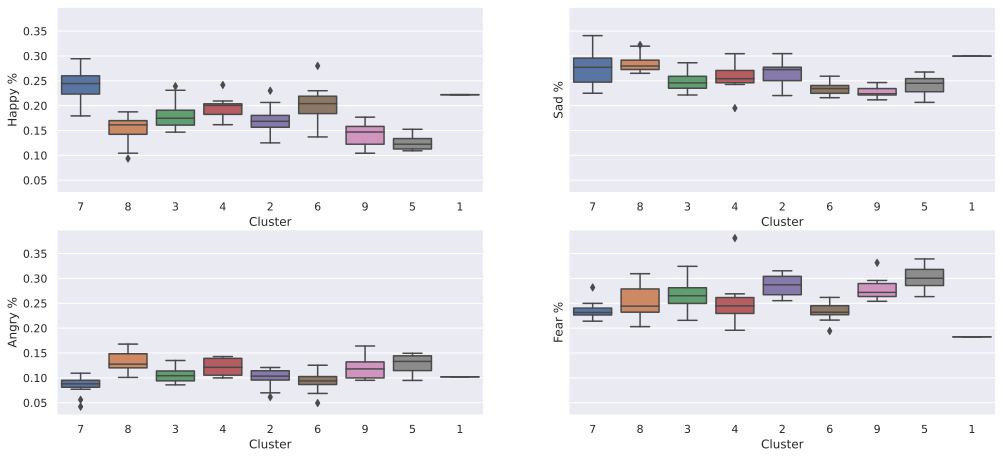

In [ ]:
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(15,7))

newl = []
for i in range(len(lab)):
  if lab[i] == 0:
    newl.append("1")
  if lab[i] == 1:
    newl.append("2")
  if lab[i] == 2:
    newl.append("3")
  if lab[i] == 3:
    newl.append("4")
  if lab[i] == 4:
    newl.append("5")
  if lab[i] == 5:
    newl.append("6")
  if lab[i] == 6:
    newl.append("7")
  if lab[i] == 7:
    newl.append("8")
  if lab[i] == 8:
    newl.append("9")

bp = sns.boxplot(ax=axes[0, 0], x=newl, y=df["Happy"])
bp.set(ylabel='Happy %')
bp.set(xlabel='Cluster')
bp = sns.boxplot(ax=axes[0, 1], x=newl, y=df["Sad"])
bp.set(ylabel='Sad %')
bp.set(xlabel='Cluster')
bp = sns.boxplot(ax=axes[1, 0], x=newl, y=df["Angry"])
bp.set(ylabel='Angry %')
bp.set(xlabel='Cluster')
bp = sns.boxplot(ax=axes[1, 1], x=newl, y=df["Fear"])
bp.set(ylabel='Fear %')
bp.set(xlabel='Cluster')

plt.savefig("boxplot_cluster.png", bbox_inches='tight')
files.download("boxplot_cluster.png")
plt.show()

# Classification

In this section, we will try to apply some classification models in order to assign each song to the correct cluster, based on the grouos found in the previous part, as we ideally imagine that each cluster corresponds to a genre.

In [ ]:
df['cluster'] = None

for i in range(len(df)):
  if df.artist[i] in cl0:
    df['cluster'][i] = 1
  elif df.artist[i] in cl1:
    df['cluster'][i] = 2
  elif df.artist[i] in cl2:
    df['cluster'][i] = 3
  elif df.artist[i] in cl3:
    df['cluster'][i] = 4
  elif df.artist[i] in cl4:
    df['cluster'][i] = 5
  elif df.artist[i] in cl5:
    df['cluster'][i] = 6
  elif df.artist[i] in cl6:
    df['cluster'][i] = 7
  elif df.artist[i] in cl7:
    df['cluster'][i] = 8
  elif df.artist[i] in cl8:
    df['cluster'][i] = 9
df.head()

artist                                               text  \
0   ABBA  Look at her face, it's a wonderful face  \r\nA...   
1   ABBA  Take it easy with me, please  \r\nTouch me gen...   
2   ABBA  I'll never know why I had to go  \r\nWhy I had...   
3   ABBA  Making somebody happy is a question of give an...   
4   ABBA  Making somebody happy is a question of give an...   

                                           prep_text cluster  
0  look face wonderful face mean something specia...       7  
1  easy please touch gently like summer evening b...       7  
2  never know go put lousy rotten show boy tough ...       7  
3  make somebody happy question give learn show c...       7  
4  make somebody happy question give learn show c...       7

In [ ]:
df.drop(['Unnamed: 0', 'artist', 'text'], axis = 1, inplace = True)

In [ ]:
#import pandas as pd
# df.to_csv('classification_dataset.csv')
#df = pd.read_csv('classification_dataset.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df['cluster'] = df['cluster'].astype(str)

## Create train, dev and test sets

In [ ]:
rand = 22

# create training set
train = df.sample(frac=0.7,random_state = rand)
not_train = df.drop(train.index)

# create development set
dev = not_train.sample(frac = 0.5, random_state = rand)

# create test set
test = not_train.drop(dev.index)

# reset indexes of all
train.reset_index(drop = True, inplace = True)
dev.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
y_train = train['cluster']
y_dev = dev['cluster']
y_test = test['cluster']

In [ ]:
# dictionary to store F-1scores of the different models
test_scores = {}

## Logistic 2-6 gram characters baseline

The first way we asses the performance of our classification is using the logistic 2-6 gram baseline, thus we create the Tf-idf character matrix and fit with it a simple logistic regression.

### Tf-idf 2-6 gram char

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_bl = TfidfVectorizer(ngram_range=(2,6),
                             min_df=0.001,
                             max_df=0.7,
                             analyzer='char',
                             sublinear_tf=True
                            )

X_train_bl = vectorizer_bl.fit_transform(train['prep_text'])
print(X_train_bl.shape)

(7054, 130299)


In [ ]:
X_dev_bl = vectorizer_bl.transform(dev['prep_text'])
X_test_bl = vectorizer_bl.transform(test['prep_text'])
print(X_dev_bl.shape, X_test_bl.shape)

(1512, 130299) (1511, 130299)


In [ ]:
from sklearn.linear_model import LogisticRegression

log_bl = LogisticRegression(n_jobs=-1,multi_class='auto', solver='lbfgs', penalty='l2', class_weight='balanced')
%time log_bl.fit(X_train_bl, y_train)
print(log_bl)

CPU times: user 291 ms, sys: 150 ms, total: 441 ms
Wall time: 55.6 s
LogisticRegression(class_weight='balanced', n_jobs=-1)


In [ ]:
predictions_bl = log_bl.predict(X_dev_bl)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
f1_score(y_dev, predictions_bl, average='micro')

0.4623015873015873

 We then found the best combination of hyperparameters on development data. In order to prevent the model from overfitting, it is convenient to regularize our model. In fact, L2 regularization turned out ot be the most appropriate one. (already used as default parameter in the 2-6 char baseline)

In [ ]:
import tqdm

regs = ['elasticnet', 'l1', 'l2', 'none']
scores = []
ratio = None

for reg in tqdm.tqdm(regs):
    if reg == 'elasticnet':
        ratio = 0.5
    classifier = LogisticRegression(solver='saga', penalty=reg, l1_ratio=ratio)
    classifier.fit(X_train_bl, y_train)
    predictions = classifier.predict(X_dev_bl)
    scores.append(f1_score(y_dev, predictions, average='micro'))

 25%|██▌       | 1/4 [00:55<02:47, 55.87s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 2/4 [04:35<05:04, 152.00s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
 75%|███████▌  | 3/4 [05:41<01:52, 112.83s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been

In [ ]:
scores

[0.3862433862433862,
 0.3630952380952381,
 0.45965608465608465,
 0.44907407407407407]

In [ ]:
best = LogisticRegression(solver = 'saga', penalty = 'l2', l1_ratio = None)

Eventually we evaluate our baseline with the test data, and we find the final estimate of the test error with this model. We obtained a f1-score of 42.95%, 4% less than our development error estimate as maybe we overfit the development data a little bit.

In [ ]:
predictions_bl_test = log_bl.predict(X_test_bl)

f1 = f1_score(y_test, predictions_bl_test, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))
print(classification_report(y_test, predictions_bl_test))

F1 Micro Score: 0.4295
              precision    recall  f1-score   support

           1       0.16      0.15      0.15        27
           2       0.39      0.44      0.41       229
           3       0.53      0.37      0.43       389
           4       0.45      0.47      0.46       154
           5       0.26      0.42      0.32        97
           6       0.39      0.34      0.36       106
           7       0.44      0.41      0.42       236
           8       0.37      0.44      0.40       181
           9       0.72      0.83      0.77        92

    accuracy                           0.43      1511
   macro avg       0.41      0.43      0.41      1511
weighted avg       0.44      0.43      0.43      1511



In [ ]:
test_scores['Logistic 2-6 char grams'] = f1_score(y_test, predictions_bl_test, average='micro')

We then tried the Logistic Regression model using as input matrix the **TF-IDF 2-4 gram char**.

### Tf-idf 2-4 gram char

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_2 = TfidfVectorizer(ngram_range=(2,4),
                             min_df=0.001,
                             max_df=0.8,
                             analyzer='char',
                             sublinear_tf=True
                            )

X_train_2 = vectorizer_2.fit_transform(train['prep_text'])
print(X_train_2.shape)

(7054, 23414)


In [ ]:
X_dev_2 = vectorizer_2.transform(dev['prep_text'])
X_test_2 = vectorizer_2.transform(test['prep_text'])
print(X_dev_2.shape, X_test_2.shape)

(1512, 23414) (1511, 23414)


Again, we implement a Logistic Regression but this time with a Tf-idf matrix with 2-4 grams, using gridsearch CV to tune the penalty parameter and choose the type of penalty.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid_param_lr = { "penalty": ['l2', 'l1'],
             "C": [20, 10, 7, 5, 1, 0.5, 0.1]}

gridsearch_lr = GridSearchCV(LogisticRegression(max_iter = 500, solver = 'liblinear'), param_grid = grid_param_lr,
                             cv = 5, verbose = 1, n_jobs = -1, scoring = "f1_micro")
gridsearch_lr.fit(X_train_2, y_train)
best_lr = gridsearch_lr.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [ ]:
# chosen parameters
gridsearch_lr.best_params_

{'C': 5, 'penalty': 'l2'}

In [ ]:
from sklearn.metrics import f1_score

predictions_lr = best_lr.predict(X_dev_2)
f1_score(y_dev, predictions_lr, average='micro')

0.48478835978835977

In [ ]:
best_clf = LogisticRegression(C = 5, max_iter = 500, solver = 'liblinear', penalty = 'l2')
best_clf.fit(X_train_2, y_train)
predictions_lg_test = best_clf.predict(X_test_2)

f1 = f1_score(y_test, predictions_lg_test, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))
print(classification_report(y_test, predictions_lg_test))

F1 Micro Score: 0.4467
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        27
           2       0.38      0.37      0.37       229
           3       0.43      0.65      0.52       389
           4       0.51      0.44      0.47       154
           5       0.43      0.23      0.30        97
           6       0.38      0.14      0.21       106
           7       0.46      0.42      0.44       236
           8       0.38      0.36      0.37       181
           9       0.79      0.74      0.76        92

    accuracy                           0.45      1511
   macro avg       0.42      0.37      0.38      1511
weighted avg       0.44      0.45      0.43      1511



In [ ]:
test_scores['Logistic 2-4 char grams'] = f1_score(y_test, predictions_lg_test, average='micro')

### Further optimization steps

To improve our code we also tried to implement a pipeline that encode the categories, scale the features and then apply the model seen before. We applied this method on the X obtained with Tf-idf 2-4 gram char since it was the one performing better. However the final f1 score has not improved much, this is the method that scored the highest f1.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),  # One Hot Encoder for feature encoding
    ('scaler', StandardScaler(with_mean=False, with_std=False)),  # Standard Scaler for feature scaling
    ('classifier', best_clf)  # The classifier
])

pipe.fit(X_train_2.toarray(), y_train)

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('classifier',
                 LogisticRegression(C=5, max_iter=500, solver='liblinear'))])

In [ ]:
predictions_pp = pipe.predict(X_dev_2.toarray())
f1_score(y_dev, predictions_pp, average='micro')

0.4728835978835979

In [ ]:
predictions_pp_test = pipe.predict(X_test_2.toarray())

f1 = f1_score(y_test, predictions_pp_test, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))
print(classification_report(y_test, predictions_pp_test))

F1 Micro Score: 0.4480
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        27
           2       0.40      0.39      0.39       229
           3       0.44      0.65      0.52       389
           4       0.51      0.41      0.45       154
           5       0.37      0.23      0.28        97
           6       0.44      0.16      0.23       106
           7       0.46      0.42      0.44       236
           8       0.37      0.36      0.37       181
           9       0.75      0.74      0.74        92

    accuracy                           0.45      1511
   macro avg       0.41      0.37      0.38      1511
weighted avg       0.44      0.45      0.43      1511



In [ ]:
test_scores['Logistic 2-4 grams + pipeline'] = f1_score(y_test, predictions_pp_test, average='micro')

## Other predictive models:

### SVM

Using the same Tf-idf 2-4 grams matrix, we consider a SVM model. Because of the very large size of the feature matrix, this procedure is computationally expensive. Therefore, instead of CV we try different combinations of parameters on the development set. In particular, we tune the type of kernel used, and the values of C and gamma.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

cs = [0.1, 10, 100]
kers = ['linear', 'rbf']
gs = ['auto', 'scale']

scores_svm = {}

for ker in kers:
    for c in cs:
        for g in gs:
            SVM = SVC(C=c, kernel=ker, gamma=g)
            SVM.fit(X_train_2, y_train)
            predictions = SVM.predict(X_dev_2)
            scores_svm[(ker, c, g)] = f1_score(y_dev, predictions, average='micro')

In [ ]:
scores_svm

{('linear', 0.1, 'auto'): 0.32076719576719576,
 ('linear', 0.1, 'scale'): 0.32076719576719576,
 ('linear', 10, 'auto'): 0.43253968253968256,
 ('linear', 10, 'scale'): 0.43253968253968256,
 ('linear', 100, 'auto'): 0.4332010582010582,
 ('linear', 100, 'scale'): 0.4332010582010582,
 ('rbf', 0.1, 'auto'): 0.2916666666666667,
 ('rbf', 0.1, 'scale'): 0.2916666666666667,
 ('rbf', 10, 'auto'): 0.2916666666666667,
 ('rbf', 10, 'scale'): 0.48677248677248675,
 ('rbf', 100, 'auto'): 0.2916666666666667,
 ('rbf', 100, 'scale'): 0.48743386243386244}

The best SVM is the one with the rbf kernel, C = 100 and gamma set to 'scale'. We compute its predictions on the test set.

In [ ]:
svm_best = SVC(C = 100, kernel = 'rbf', gamma = 'scale')
svm_best.fit(X_train_2, y_train)
predictions_svm = svm_best.predict(X_test_2)

f1 = f1_score(y_test, predictions_svm, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))

F1 Micro Score: 0.4434


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_svm))

              precision    recall  f1-score   support

           1       0.25      0.04      0.06        27
           2       0.38      0.39      0.39       229
           3       0.40      0.69      0.51       389
           4       0.53      0.41      0.46       154
           5       0.64      0.19      0.29        97
           6       0.40      0.13      0.20       106
           7       0.45      0.36      0.40       236
           8       0.41      0.35      0.38       181
           9       0.84      0.73      0.78        92

    accuracy                           0.44      1511
   macro avg       0.48      0.37      0.39      1511
weighted avg       0.46      0.44      0.43      1511



In [ ]:
# store the performance
test_scores['SVM (rbf, C = 100)'] = f1_score(y_test, predictions_svm, average='micro')

### Random Forest

Then, we run a random forest, using Grid Search CV to choose between the gini criterion and entropy. However the results are worse than the baseline. Indeed,the test error estimate is 36%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_param = {"criterion": ['gini', 'entropy']}

gridsearch = GridSearchCV(RandomForestClassifier(random_state=1, n_estimators=300),
                          param_grid = grid_param, cv = 5, verbose = 1, n_jobs = -1, scoring = "f1")
best_rf = gridsearch.fit(X_train_2, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [ ]:
gridsearch.best_params_

{'criterion': 'gini'}

In [ ]:
from sklearn.metrics import classification_report
predictions_rf = best_rf.predict(X_test_2)

f1 = f1_score(y_test, predictions_rf, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))

F1 Micro Score: 0.3620


In [ ]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           1       0.25      0.04      0.06        27
           2       0.46      0.17      0.25       229
           3       0.31      0.90      0.46       389
           4       0.50      0.18      0.26       154
           5       1.00      0.02      0.04        97
           6       0.40      0.02      0.04       106
           7       0.45      0.19      0.27       236
           8       0.36      0.08      0.13       181
           9       0.81      0.72      0.76        92

    accuracy                           0.36      1511
   macro avg       0.50      0.26      0.25      1511
weighted avg       0.46      0.36      0.29      1511



In [ ]:
test_scores['Random Forest'] = f1_score(y_test, predictions_rf, average='micro')

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [ ]:
# define the model
gb = GradientBoostingClassifier()

# define the f1 macro score as the metric for evaluation
scorer = make_scorer(f1_score, average='macro')

In [ ]:
# define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.5, 0.8, 1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
}

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# define the randomized search
RS = RandomizedSearchCV(
    gb,
    param_grid,
    n_iter=10,
    cv=cv,
    scoring=scorer,
    random_state=42
)

In [ ]:
RS.fit(X_train_2, y_train)

In [ ]:
# get the best model
gb_model = RS.best_estimator_

In [ ]:
RS.best_params_

In [ ]:
# to save and reload the model
from joblib import dump

# saving the model
dump(best_model, 'modello_gb.joblib')

#import joblib

# load the model
#model = joblib.load('modello_gb.joblib')

In [ ]:
predictions_gb = gb_model.predict(X_test_2)

f1 = f1_score(y_test, predictions_gb, average='micro')
print("F1 Micro Score: {:.4f}".format(f1))

In [ ]:
print(classification_report(y_test, predictions_gb))

In [ ]:
test_scores['Gradient Boosting'] = f1_score(y_test, predictions_gb, average='micro')

### Convolutional Neural Network

We will now try to implement a convolutional neural network to see if the accuracy of the model can improve.

In [ ]:
!pip install --upgrade keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

In [ ]:
X_train = train['prep_text']
X_dev = dev['prep_text']
X_test = test['prep_text']

In [ ]:
y_train = train['cluster']
y_dev = dev['cluster']
y_test = test['cluster']

In [ ]:
num_classes = len(np.unique(y_train))
num_classes

9

We start encoding the target variable and then tokenizing and padding the song lyrics.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_dev = le.transform(y_dev)
y_test = le.transform(y_test)

In [ ]:
# Convert the labels to categorical format
y_train = to_categorical(y_train, num_classes)
y_dev = to_categorical(y_dev, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(X_train[2])

X_train = tokenizer.texts_to_sequences(X_train)
X_dev = tokenizer.texts_to_sequences(X_dev)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])

sight vision still mind memory remain unchanged stone throw anger hold twice hurt return sender could thing bad girl get break chain around heart lonely long get break chain around heart finally get life ask live alone lock inside cut bone love stranger avoid beware danger sign see listen something would like say getting go leave way girl get break chain around heart tear two get break chain around heart ask get break chain around heart lonely long get break chain around heart finally get life
[520, 646, 67, 60, 442, 903, 11203, 369, 279, 924, 58, 723, 195, 682, 8037, 32, 40, 100, 22, 1, 70, 499, 53, 33, 250, 51, 1, 70, 499, 53, 33, 563, 1, 34, 190, 55, 110, 635, 118, 353, 514, 3, 906, 2742, 1817, 844, 518, 11, 223, 80, 20, 6, 8, 1252, 2, 41, 23, 22, 1, 70, 499, 53, 33, 153, 143, 1, 70, 499, 53, 33, 190, 1, 70, 499, 53, 33, 250, 51, 1, 70, 499, 53, 33, 563, 1, 34]


In [ ]:
# Pad the sequences to a fixed length
maxlen = 1000
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_dev = pad_sequences(X_dev, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')
num_classes = len(np.unique(y_train))
print(X_train[0, :])

We want now to compute word embeddings using a pretrained model (GloVe) trained on a larger corpus of data.

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B.100d.txt',
    tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7470256253813301

The 75% of the words in the song lyrics are recognized by the pre-trained model.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

Now we define a function to build the neural networks; we will use it to develop different models and compare their performances and retrieve the optimal hyperparameters

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D()) #MaxPooling1D(pool_size=2)
    model.add(Dense(10, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=10, batch_size=32,
                        verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=5, verbose=1, n_iter=5)

<ipython-input-197-0f11dc726913>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


In [ ]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
dev_accuracy = grid.score(X_dev, y_dev)
dev_accuracy

0.3373015820980072

In [ ]:
test_accuracy = grid.score(X_test, y_test)
test_accuracy

0.3335539400577545

In [ ]:
grid.best_params_

{'vocab_size': 26224,
 'num_filters': 64,
 'maxlen': 1000,
 'kernel_size': 3,
 'embedding_dim': 50}

Here we run the model with the optimal parameters obtained with the Randomized Search

In [ ]:
# Define the model
model = Sequential()
#model.add(Embedding(input_dim=5000, output_dim=50, input_length=maxlen))
model.add(Embedding(26224, 50,
                           weights=[embedding_matrix],
                           input_length=1000,
                           trainable=True))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D()) #MaxPooling1D(pool_size=2)
model.add(Dense(10, activation='relu'))
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 1000, 50)          1311200   
                                                                 
 conv1d_46 (Conv1D)          (None, 998, 64)           9664      
                                                                 
 global_max_pooling1d_55 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_109 (Dense)           (None, 10)                650       
                                                                 
 dense_110 (Dense)           (None, 9)                 99        
                                                                 
Total params: 1,321,613
Trainable params: 1,321,613
Non-trainable params: 0
___________________________________________

We defined the EarlyStopping to choose the model that gives us the highest categorical accuracy. Indeed, with higher epochs we were able to increase the train fit however resulting rapidly in an overfitting trend, thus sacrificing the test categorical accuracy.

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=2, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_dev, y_dev), callbacks=[early_stopping])

Epoch 1/10
221/221 [==============================] - 26s 112ms/step - loss: 2.0168 - categorical_accuracy: 0.2745 - val_loss: 1.9378 - val_categorical_accuracy: 0.2844
Epoch 2/10
221/221 [==============================] - 24s 110ms/step - loss: 1.8210 - categorical_accuracy: 0.3380 - val_loss: 1.8508 - val_categorical_accuracy: 0.3168
Epoch 3/10
221/221 [==============================] - 25s 114ms/step - loss: 1.6475 - categorical_accuracy: 0.4030 - val_loss: 1.8021 - val_categorical_accuracy: 0.3347
Epoch 4/10
221/221 [==============================] - 24s 109ms/step - loss: 1.4539 - categorical_accuracy: 0.4972 - val_loss: 1.7820 - val_categorical_accuracy: 0.3565
Epoch 5/10
221/221 [==============================] - 24s 109ms/step - loss: 1.2167 - categorical_accuracy: 0.5920 - val_loss: 1.8055 - val_categorical_accuracy: 0.3492
Epoch 6/10
221/221 [==============================] - 24s 110ms/step - loss: 0.9642 - categorical_accuracy: 0.6868 - val_loss: 1.8782 - val_categorical_acc

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

48/48 [==============================] - 1s 30ms/step - loss: 1.8022 - categorical_accuracy: 0.3527
Test loss: 1.8022119998931885
Test accuracy: 0.35274651646614075


In [ ]:
# Get predicted values of y for the test data
y_pred = model.predict(X_test)

# Convert predicted y values from categorical to integer format
y_pred_int = np.argmax(y_pred, axis=1)

# Convert true y values from categorical to integer format
y_test_int = np.argmax(y_test, axis=1)


48/48 [==============================] - 1s 23ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test_int, y_pred_int)
precision = precision_score(y_test_int, y_pred_int, average='macro')
recall = recall_score(y_test_int, y_pred_int, average='macro')
f1 = f1_score(y_test_int, y_pred_int, average='macro')

print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))

Accuracy: 0.35
Precision: 0.28
Recall: 0.24
F1 score: 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparison of all models

In [ ]:
df_scores = pd.DataFrame([test_scores]).T.rename(columns = {0:'F1-micro on test set'})
df_scores.sort_values(by = 'F1-micro on test set', ascending = False)

F1-micro on test set
Logistic 2-4 grams + pipeline              0.448048
Logistic 2-4 char grams                    0.446724
SVM (rbf, C = 100)                         0.443415
Logistic 2-6 char grams                    0.429517
Random Forest                              0.362012

The Pipeline with Logistic 2-4 grams is the best performing model, even though all models seem to have a very similar performance.

### Confusion Matrix

Here there are the confusion matrices of the baseline and of our best model. Even if the performance improves, the number of false posivites and false negatives of the logistic baseline and our best model is still very similar.

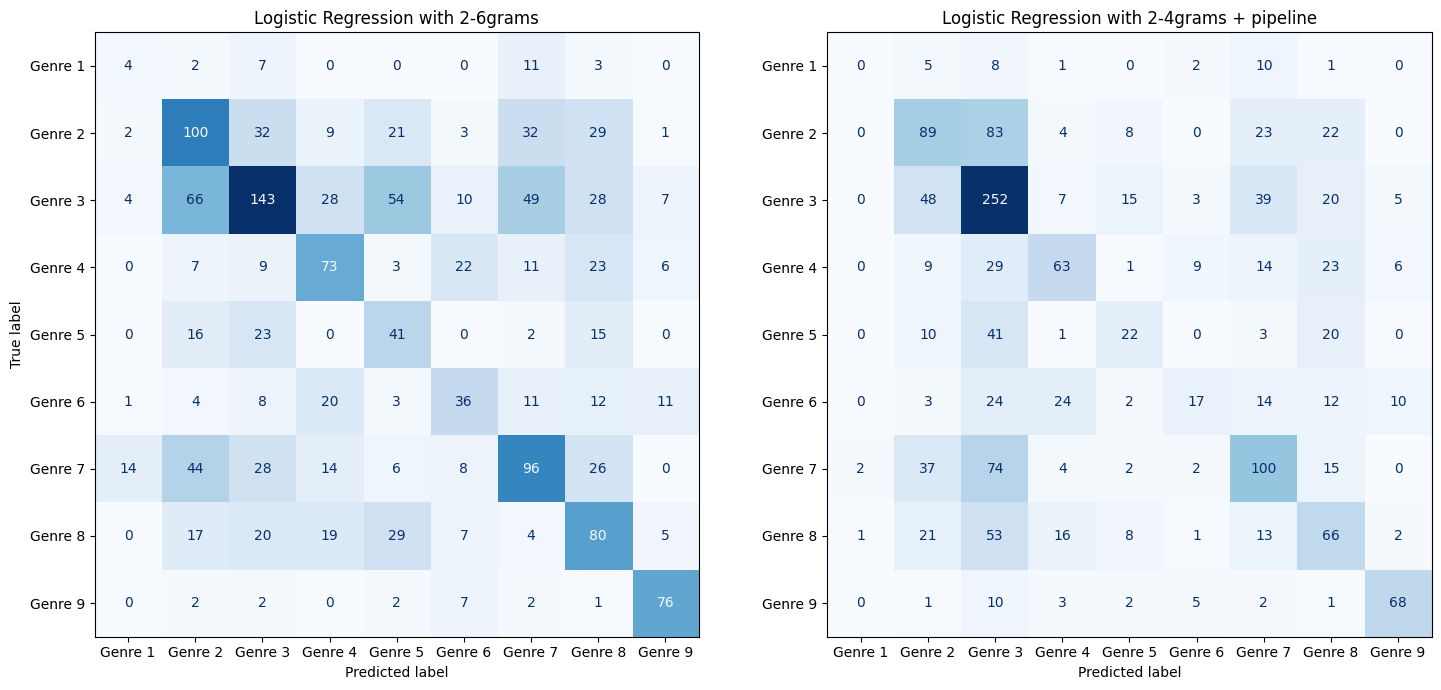

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(15, 7))

all_pred = {'Logistic Regression with 2-6grams':predictions_bl_test, 'Logistic Regression with 2-4grams + pipeline':predictions_pp_test}

for i, pred in enumerate(all_pred.items()):
    cm = confusion_matrix(y_test, pred[1].astype(str), labels=['1', '2', '3', '4', '5', '6', '7', '8', '9'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6', 'Genre 7', 'Genre 8', 'Genre 9'])
    disp.plot(cmap=plt.cm.Blues, ax=axes[i])
    disp.ax_.set_title(pred[0])
    disp.im_.colorbar.remove()
    if i % 3 != 0:
        disp.ax_.set_ylabel('')
    plt.tight_layout()

### Bootstrap sampling significance tests

With a 44.8% testing accuracy our best model is a Logistic Regression with 2-4 gram char implemented through a pipeline that encode the categories. However, the difference with the logistic baseline is really small so it might be useful to control for it using a bootstrap significance test.
The goal is to determine if the performance difference between the two systems on a subsample is significantly different from the performance difference on the entire sample.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the
    two systems on a subsample is significantly different from the
    performance on the entire sample
    """
    N = len(gold) # number of instances

    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1

    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)

    return p/samples, deltas

In [ ]:
p_value, deltas = bootstrap_sample(predictions_pp_test, predictions_bl_test, y_test)
print(p_value, p_value < 0.01) # statistically significant

Base difference: 0.44804765056254137 vs. 0.42951687624090007
0.067 False


A p-value of 0.067 indicates that the observed difference in performance between the two classification models on the subsamples is not statistically significant at the conventional significance level of 0.05.  Thus, there is not enough evidence to conclude that one system consistently outperforms the other on the subsamples. However, since the p-value is relatively close to the significance level (0.05), we might consider the result as marginally significant.

<Axes: ylabel='Count'>

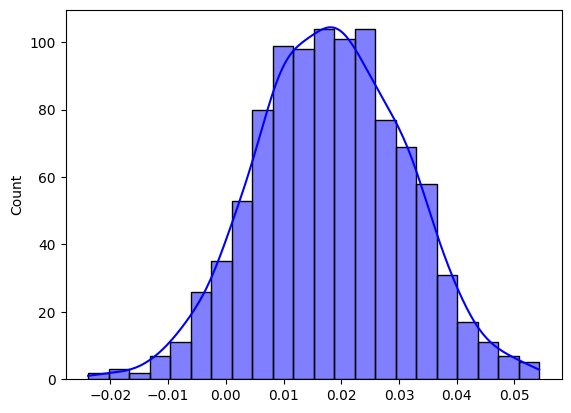

In [ ]:
import seaborn as sns

sns.histplot(data=deltas,kde=True,color='blue')

# Bonus part: lyrics generation

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("ABBA.csv")
df

artist                                               text  \
0     ABBA  Look at her face, it's a wonderful face  \r\nA...   
1     ABBA  Take it easy with me, please  \r\nTouch me gen...   
2     ABBA  I'll never know why I had to go  \r\nWhy I had...   
3     ABBA  Making somebody happy is a question of give an...   
4     ABBA  Making somebody happy is a question of give an...   
..     ...                                                ...   
108   ABBA  Went to buy me a paper at the local news-stand...   
109   ABBA  Here's to us one more toast and then we'll pay...   
110   ABBA  Everybody screamed when I kissed the teacher  ...   
111   ABBA  When you were lonely, you needed a man  \r\nSo...   
112   ABBA  Frida Now there's a shadow falling over our fa...   

                                             prep_text  
0    look face wonderful face mean something specia...  
1    easy please touch gently like summer evening b...  
2    never know go put lousy rotten show boy tough ...  
3    make somebody happy question give learn show c...  
4    make somebody happy question give learn show c...  
..                                                 ...  
108  go buy paper local newsstand hear laugh say lo...  
109  we one toast pay bill deep inside we feel autu...  
110  everybody scream kiss teacher must think dream...  
111  lonely need man someone lean well understand n...  
112  frida shadow fall face doubt forever heart sta...  

[113 rows x 3 columns]

In [ ]:
c = list(df["prep_text"])
corpus = c[:2]
corpus

['look face wonderful face mean something special look way smile see lucky one fellow kind girl make feel fine could ever believe could mine kind girl without blue ever leave could could go walk park hold squeeze hand go walk hour talk thing plan kind girl make feel fine could ever believe could mine kind girl without blue ever leave could could',
 'easy please touch gently like summer evening breeze time slow andante andante let feel grow finger soft light let body velvet night touch soul know andante andante go slowly music music song song music song play time time strong play make strong sing sound sing andante andante tread lightly grind andante andante oh please let shimmer eye like feel thousand butterfly please talk go play andante andante let float away music music song song music song play time time strong play make strong sing sound sing andante andante tread lightly grind andante andante oh please let sing sound sing andante andante tread lightly grind andante andante oh ple

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
reverse_word_index = dict([(v,k) for (k,v) in word_index.items()])

TOTAL_WORDS = len(word_index) + 1
print ('Total Words :', TOTAL_WORDS)

Total Words : 73


In [ ]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

In [ ]:
MAX_SEQ_LEN = max([len(x) for x in input_sequences])
print ('Max Sequence Length :', MAX_SEQ_LEN)

Max Sequence Length : 114


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen = MAX_SEQ_LEN, padding = 'pre'))

xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes = TOTAL_WORDS)
xs.shape, ys.shape

((174, 113), (174, 73))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
model = Sequential([
    Embedding(TOTAL_WORDS, 256, input_length = MAX_SEQ_LEN - 1),
    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(TOTAL_WORDS, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()
%time history = model.fit(xs, ys, epochs = 200, verbose = 0, batch_size = 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 113, 256)          18688     
                                                                 
 bidirectional (Bidirectiona  (None, 113, 256)         394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 73)                18761     
                                                                 
Total params: 825,929
Trainable params: 825,929
Non-trai

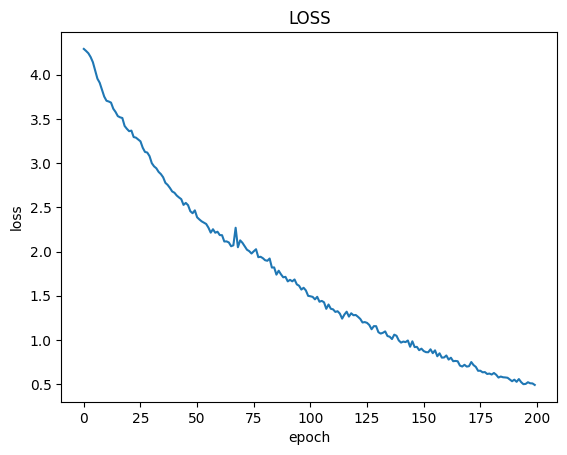

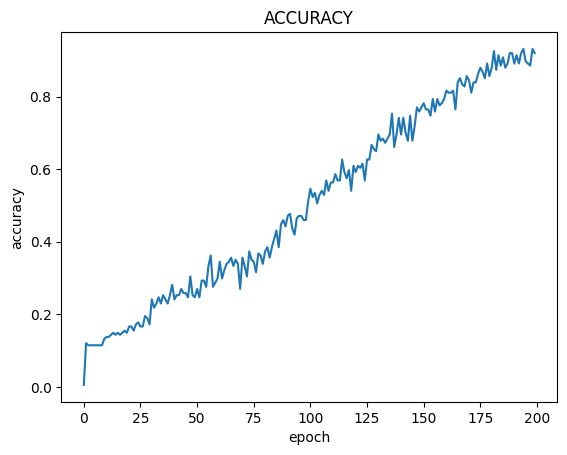

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
seed_text  = 'Dancing queen'
next_words = 50
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen = MAX_SEQ_LEN - 1, padding = 'pre')
    predicted  = model.predict(token_list, verbose = 0)
    seed_text += ' ' + reverse_word_index[predicted[0]]
print (seed_text)

1/1 [==============================] - 0s 129ms/step


TypeError: ignored

In [ ]:
seed_text = 'Dancing queen'
next_words = 50

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LEN - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted[0])  # Get the index of the predicted word
    predicted_word = reverse_word_index[predicted_word_index]  # Get the predicted word

    seed_text += ' ' + predicted_word

print(seed_text)


Dancing queen face face face face mean something special way smile see lucky one fellow kind girl make feel fine could ever believe could mine kind girl without blue ever leave could could go walk park hold squeeze hand go walk hour talk thing plan kind girl make feel fine could ever


In [ ]:
df = pd.read_csv("ABBA-no-lem.csv")
df

artist                       song  \
0     ABBA      Ahe's My Kind Of Girl   
1     ABBA           Andante, Andante   
2     ABBA             As Good As New   
3     ABBA                       Bang   
4     ABBA           Bang-A-Boomerang   
..     ...                        ...   
108   ABBA     What About Livingstone   
109   ABBA  When All Is Said And Done   
110   ABBA  When I Kissed The Teacher   
111   ABBA  Why Did It Have To Be Me?   
112   ABBA             You Owe Me One   

                                                link  \
0         /a/abba/ahes+my+kind+of+girl_20598417.html   
1              /a/abba/andante+andante_20002708.html   
2               /a/abba/as+good+as+new_20003033.html   
3                         /a/abba/bang_20598415.html   
4             /a/abba/bang+a+boomerang_20002668.html   
..                                               ...   
108     /a/abba/what+about+livingstone_20003055.html   
109      /a/abba/when+all+is+said+done_20003009.html   
110  /a/abba/when+i+kissed+the+teacher_20002628.html   
111   /a/abba/why+did+it+have+to+be+me_20002575.html   
112             /a/abba/you+owe+me+one_10001488.html   

                                                  text  \
0    Look at her face, it's a wonderful face  \r\nA...   
1    Take it easy with me, please  \r\nTouch me gen...   
2    I'll never know why I had to go  \r\nWhy I had...   
3    Making somebody happy is a question of give an...   
4    Making somebody happy is a question of give an...   
..                                                 ...   
108  Went to buy me a paper at the local news-stand...   
109  Here's to us one more toast and then we'll pay...   
110  Everybody screamed when I kissed the teacher  ...   
111  When you were lonely, you needed a man  \r\nSo...   
112  Frida Now there's a shadow falling over our fa...   

                                             prep_text  
0    look at her face its a wonderful face and it m...  
1    take it easy with me please touch me gently li...  
2    ill never know why i had to go why i had to pu...  
3    making somebody happy is a question of give an...  
4    making somebody happy is a question of give an...  
..                                                 ...  
108  went to buy me a paper at the local newsstand ...  
109  heres to us one more toast and then well pay t...  
110  everybody screamed when i kissed the teacher a...  
111  when you were lonely you needed a man someone ...  
112  frida now theres a shadow falling over our fac...  

[113 rows x 5 columns]

In [ ]:
c = list(df["prep_text"])
corpus = c[:50]
corpus

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
reverse_word_index = dict([(v,k) for (k,v) in word_index.items()])

TOTAL_WORDS = len(word_index) + 1
print ('Total Words :', TOTAL_WORDS)

Total Words : 1465


In [ ]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

In [ ]:
MAX_SEQ_LEN = max([len(x) for x in input_sequences])
print ('Max Sequence Length :', MAX_SEQ_LEN)

Max Sequence Length : 566


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen = MAX_SEQ_LEN, padding = 'pre'))

xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes = TOTAL_WORDS)
xs.shape, ys.shape

((12243, 565), (12243, 1465))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
model = Sequential([
    Embedding(TOTAL_WORDS, 256, input_length = MAX_SEQ_LEN - 1),
    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(TOTAL_WORDS, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()
%time history = model.fit(xs, ys, epochs = 200, verbose = 0, batch_size = 256)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 565, 256)          375040    
                                                                 
 bidirectional_4 (Bidirectio  (None, 565, 256)         394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1465)              376505    
                                                                 
Total params: 1,540,025
Trainable params: 1,540,025
No

In [ ]:
seed_text = 'Dancing queen'
next_words = 50

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LEN - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted[0])  # Get the index of the predicted word
    predicted_word = reverse_word_index[predicted_word_index]  # Get the predicted word

    seed_text += ' ' + predicted_word

print(seed_text)

Dancing queen can you hear the drums fernando i remember long ago another starry night like this bang a boomaboomerang dumbedumdum bedumbedumdum oh bang a boomaboomerang is love a boomaboomerang is love love is always around and you can look for it oh lord im blue im cryin over you oh im
